<h1>Análise e Correlações do Preço do Frete na Importação</h1>
<hr>

## Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Bibliotecas

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

import re

## Coleta, Processamento e Tratamento dos dados
---


### Importação Brasil
Link: [Ministério da Economia](https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/IMP_COMPLETA.zip)

In [3]:
df_importacao = pd.read_csv("/content/drive/Shareddrives/TCC Daniel dados/IMP_COMPLETA.csv",sep=';')
#df_importacao = pd.read_csv('../datasets/IMP_COMPLETA.csv',sep=';')
df_importacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36389808 entries, 0 to 36389807
Data columns (total 13 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CO_ANO      int64 
 1   CO_MES      int64 
 2   CO_NCM      int64 
 3   CO_UNID     int64 
 4   CO_PAIS     int64 
 5   SG_UF_NCM   object
 6   CO_VIA      int64 
 7   CO_URF      int64 
 8   QT_ESTAT    int64 
 9   KG_LIQUIDO  int64 
 10  VL_FOB      int64 
 11  VL_FRETE    int64 
 12  VL_SEGURO   int64 
dtypes: int64(12), object(1)
memory usage: 3.5+ GB


In [ ]:
df_importacao.isnull().sum()

CO_ANO        0
CO_MES        0
CO_NCM        0
CO_UNID       0
CO_PAIS       0
SG_UF_NCM     0
CO_VIA        0
CO_URF        0
QT_ESTAT      0
KG_LIQUIDO    0
VL_FOB        0
VL_FRETE      0
VL_SEGURO     0
dtype: int64

In [ ]:
df_importacao.duplicated().sum()

0

In [ ]:
print(f'Menor ano: {df_importacao.CO_ANO.min()}\nMaior ano: {df_importacao.CO_ANO.max()}')

Menor ano: 1997
Maior ano: 2022


**Separando dados de 10 anos atrás (2012 - 2022)**

In [4]:
df_importacao = df_importacao[df_importacao.CO_ANO >= 2012]
df_importacao.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18689502 entries, 17700306 to 36389807
Data columns (total 13 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CO_ANO      int64 
 1   CO_MES      int64 
 2   CO_NCM      int64 
 3   CO_UNID     int64 
 4   CO_PAIS     int64 
 5   SG_UF_NCM   object
 6   CO_VIA      int64 
 7   CO_URF      int64 
 8   QT_ESTAT    int64 
 9   KG_LIQUIDO  int64 
 10  VL_FOB      int64 
 11  VL_FRETE    int64 
 12  VL_SEGURO   int64 
dtypes: int64(12), object(1)
memory usage: 1.9+ GB


In [6]:
df_importacao.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
17700306,2012,10,85441990,10,399,SP,4,817700,0,0,134,24,0
17700307,2012,10,85115010,11,149,SP,4,817600,1,1,36833,21,11
17700308,2012,3,90013000,11,365,SP,4,817600,6950,153,20755,992,8
17700309,2012,4,39269090,10,493,SP,4,817600,219,219,3180,3659,4
17700310,2012,3,58012100,10,160,SC,1,927800,21101,21101,55922,3372,0


### Tabelas auxiliares
---
Link: [Tabela Códigos](https://balanca.economia.gov.br/balanca/bd/tabelas/TABELAS_AUXILIARES.xlsx)

Indice Excel usado
* 1 (NO_NCM_POR): Descrição NCM
* 10 (CO_PAIS): País de origem do produto
* 14 (CO_VIA): Meio de transporte da mercadoria
* 15 (CO_URF): Local de chegada no Brasil da mercadoria
* 12 (SG_UF): Sigla do estado de origem


Da mesma forma, a formatação dos dados está correta e também não há dados nulos não havendo necessidade de tratá-los.

In [5]:
############ Tabela disponível no github ############

url = "https://github.com/Migliorin/Comex_Data_Analysis/blob/main/datasets/TABELAS_AUXILIARES.xlsx?raw=true"
xl_file = pd.ExcelFile(url)

#####################################################

#xl_file = pd.ExcelFile('../datasets/TABELAS_AUXILIARES.xlsx')
df_pais = xl_file.parse('10')
df_ncm = xl_file.parse('1')
df_via = xl_file.parse('14')
df_urf = xl_file.parse('15')
#df_uf = xl_file.parse('12')

In [ ]:
df_pais.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CO_PAIS        281 non-null    int64 
 1   CO_PAIS_ISON3  281 non-null    int64 
 2   CO_PAIS_ISOA3  281 non-null    object
 3   NO_PAIS        281 non-null    object
 4   NO_PAIS_ING    281 non-null    object
 5   NO_PAIS_ESP    281 non-null    object
dtypes: int64(2), object(4)
memory usage: 13.3+ KB


In [ ]:
df_pais.isnull().sum()

CO_PAIS          0
CO_PAIS_ISON3    0
CO_PAIS_ISOA3    0
NO_PAIS          0
NO_PAIS_ING      0
NO_PAIS_ESP      0
dtype: int64

In [ ]:
df_pais.duplicated().sum()

0

In [ ]:
df_ncm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13164 entries, 0 to 13163
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CO_NCM         13164 non-null  int64 
 1   NO_NCM_POR     13164 non-null  object
 2   CO_SH6         13164 non-null  int64 
 3   NO_SH6_POR     13164 non-null  object
 4   NO_SH6_ESP     13164 non-null  object
 5   NO_SH6_ING     13164 non-null  object
 6   CO_SH4         13164 non-null  int64 
 7   NO_SH4_POR     13164 non-null  object
 8   NO_SH4_ESP     13164 non-null  object
 9   NO_SH4_ING     13164 non-null  object
 10  CO_SH2         13164 non-null  int64 
 11  NO_SH2_POR     13164 non-null  object
 12  NO_SH2_ESP     13164 non-null  object
 13  NO_SH2_ING     13164 non-null  object
 14  CO_NCM_SECROM  13164 non-null  object
 15  NO_SEC_POR     13164 non-null  object
 16  NO_SEC_ESP     13164 non-null  object
 17  NO_SEC_ING     13164 non-null  object
dtypes: int64(4), object(14)
me

In [ ]:
df_ncm.isnull().sum()

CO_NCM           0
NO_NCM_POR       0
CO_SH6           0
NO_SH6_POR       0
NO_SH6_ESP       0
NO_SH6_ING       0
CO_SH4           0
NO_SH4_POR       0
NO_SH4_ESP       0
NO_SH4_ING       0
CO_SH2           0
NO_SH2_POR       0
NO_SH2_ESP       0
NO_SH2_ING       0
CO_NCM_SECROM    0
NO_SEC_POR       0
NO_SEC_ESP       0
NO_SEC_ING       0
dtype: int64

In [ ]:
df_ncm.duplicated().sum()

0

In [ ]:
df_via.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CO_VIA  17 non-null     int64 
 1   NO_VIA  17 non-null     object
dtypes: int64(1), object(1)
memory usage: 400.0+ bytes


In [ ]:
df_via.isnull().sum()

CO_VIA    0
NO_VIA    0
dtype: int64

In [ ]:
df_via.duplicated().sum()

0

In [ ]:
df_urf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CO_URF  276 non-null    int64 
 1   NO_URF  276 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.4+ KB


In [ ]:
df_urf.isnull().sum()

CO_URF    0
NO_URF    0
dtype: int64

In [ ]:
df_urf.duplicated().sum()

0

### Substituição código
---
Para melhor análise e entedimento, será usado a tabela de códigos para substituir os códigos dentro da base bruta. Como as colunas de alguns códigos serão traduzidas, então serão retirados as seguintes colunas:

* CO_NCM
* CO_PAIS
* CO_VIA
* CO_URF
* SG_UF_NCM

**Variável final**: df

In [6]:
df_importacao = df_importacao.merge(df_ncm[['CO_NCM','NO_NCM_POR']],on='CO_NCM').copy()
df_importacao = df_importacao.merge(df_pais[['CO_PAIS','NO_PAIS']],on='CO_PAIS')
df_importacao = df_importacao.merge(df_urf[['CO_URF','NO_URF']],on='CO_URF')
df_importacao = df_importacao.merge(df_via[['CO_VIA','NO_VIA']],on='CO_VIA')
df_importacao["NCM"] = df_importacao["CO_NCM"].map(str) + " - " + df_importacao["NO_NCM_POR"]
df_importacao.drop(['CO_NCM','CO_PAIS','CO_URF','CO_VIA', 'NO_NCM_POR'],axis=1,inplace=True)

In [7]:
df_importacao.head()

,CO_ANO,CO_MES,CO_UNID,SG_UF_NCM,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO,NO_PAIS,NO_URF,NO_VIA,NCM
0,2012,10,10,SP,0,0,134,24,0,Japão,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,AEREA,"85441990 - Outros fios para bobinar, isolados ..."
1,2012,9,10,SP,1,1,583,10,1,Japão,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,AEREA,"85441990 - Outros fios para bobinar, isolados ..."
2,2012,12,10,SP,1,1,722,10,0,Japão,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,AEREA,"85441990 - Outros fios para bobinar, isolados ..."
3,2012,8,10,SP,1,1,488,18,0,Japão,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,AEREA,"85441990 - Outros fios para bobinar, isolados ..."
4,2012,7,10,SP,1,1,1187,15,0,Japão,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,AEREA,"85441990 - Outros fios para bobinar, isolados ..."


### Dolar Série Histórica
---
Após a análise e separação da mercadoria, escolheu-se a variação da cotação do dolar para investigar se há alguma relação entre ela e o preço do frete do produto.

A base de dados foi retirada do Centro de Estudos Avançados em Economia Aplicada (CEPEA) -- Universidade de São Paulo (USP) -- contendo variações da cotação de 1996 à 2022/01

Link: [Dolar Serie Historica](https://www.cepea.esalq.usp.br/br/serie-de-preco/dolar.aspx)

In [7]:
df_dolar = pd.read_csv("/content/drive/Shareddrives/TCC Daniel dados/export_series_dolar.csv",sep=';')
df_dolar["ano"] = df_dolar["Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30"].apply(lambda x: str(x)[6:10])
df_dolar["mes"] = df_dolar["Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30"].apply(lambda x: str(x)[3:5])
df_dolar["COTACAO"] = df_dolar["Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30"].apply(lambda x: str(x)[11:])
df_dolar["COTACAO"] = df_dolar["COTACAO"].str.replace(',','.').str.replace('"','')
df_dolar.drop(['Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30'],axis=1,inplace=True)
df_dolar["ano"] = df_dolar["ano"].astype(int)
df_dolar["mes"] = df_dolar["mes"].astype(int)
df_dolar["COTACAO"] = df_dolar["COTACAO"].astype(float)
df_dolar = df_dolar[df_dolar.ano >= 2012]
df_dolar = df_dolar.groupby(['ano','mes']).mean()
df_dolar.reset_index(inplace=True)
df_dolar.info()
df_dolar.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ano      123 non-null    int64  
 1   mes      123 non-null    int64  
 2   COTACAO  123 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 3.0 KB


,ano,mes,COTACAO
0,2012,1,1.788000
1,2012,2,1.717316
2,2012,3,1.794045
3,2012,4,1.856150
4,2012,5,1.985682


### Unindo Datasets - Dolar e Importações
---


In [8]:
df_total = df_importacao.merge(df_dolar,left_on=['CO_ANO','CO_MES'],right_on=['ano','mes'])
df_total.drop(['ano','mes'],axis=1,inplace=True)
#df_total["FOB_REAIS"] = df_total.VL_FOB * df_total.COTACAO
#df_total["FOB_REAIS"] = df_total["FOB_REAIS"].astype(int)
#df_total = df_total[['CO_ANO','CO_MES','NCM','CO_UNID','NO_PAIS','SG_UF_NCM','NO_VIA','NO_URF','QT_ESTAT','KG_LIQUIDO','VL_FOB','COTACAO','FOB_REAIS','VL_SEGURO','VL_FRETE']]
df_total = df_total[['CO_ANO','CO_MES','NCM','CO_UNID','NO_PAIS','SG_UF_NCM','NO_VIA','NO_URF','QT_ESTAT','KG_LIQUIDO','VL_FOB','COTACAO','VL_SEGURO','VL_FRETE']]
df_total.head()

,CO_ANO,CO_MES,NCM,CO_UNID,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,COTACAO,FOB_REAIS,VL_SEGURO,VL_FRETE
0,2012,10,"85441990 - Outros fios para bobinar, isolados ...",10,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,0,0,134,2.029591,271,0,24
1,2012,10,85115010 - Dínamos e alternadores para motores...,11,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,20,103,10530,2.029591,21371,8,1308
2,2012,10,39269090 - Outras obras de plásticos,10,Japão,GO,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,0,0,98,2.029591,198,0,6
3,2012,10,39269090 - Outras obras de plásticos,10,Japão,PR,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,0,0,4,2.029591,8,0,2
4,2012,10,39269090 - Outras obras de plásticos,10,Japão,MG,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,614,614,23141,2.029591,46966,47,19101


## Análise e Exploração dos Dados
---


### Análise das NCM importadas

In [9]:
# Separando as 10 NCM mais importadas em valor FOB

df = df_total.groupby(['NCM']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df.iloc[:10,:][['VL_FOB']]
df.reset_index(inplace=True)
df

,NCM,VL_FOB
0,27090010 - Óleos brutos de petróleo,75347950289
1,27101921 - Gasóleo (óleo diesel),60410203617
2,27101241 - Naftas para petroquimica,32220187972
3,31042090 - Outros cloretos de potássio,30031365507
4,"87032310 - Automóveis com motor explosão, 1500...",25303488545
5,"27011200 - Hulha betuminosa, não aglomerada",22338692917
6,84119100 - Partes de turborreatores ou de turb...,22115435449
7,85299020 - Outras partes para aparelhos recept...,21794034461
8,85177099 - Outras partes para aparelhos de tel...,21708476625
9,27112100 - Gás natural no estado gasoso,21528921875


In [10]:
df_total = df_total[df_total.NCM.isin(df.NCM)]
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66230 entries, 11 to 18689501
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CO_ANO      66230 non-null  int64  
 1   CO_MES      66230 non-null  int64  
 2   NCM         66230 non-null  object 
 3   CO_UNID     66230 non-null  int64  
 4   NO_PAIS     66230 non-null  object 
 5   SG_UF_NCM   66230 non-null  object 
 6   NO_VIA      66230 non-null  object 
 7   NO_URF      66230 non-null  object 
 8   QT_ESTAT    66230 non-null  int64  
 9   KG_LIQUIDO  66230 non-null  int64  
 10  VL_FOB      66230 non-null  int64  
 11  COTACAO     66230 non-null  float64
 12  FOB_REAIS   66230 non-null  int64  
 13  VL_SEGURO   66230 non-null  int64  
 14  VL_FRETE    66230 non-null  int64  
dtypes: float64(1), int64(9), object(5)
memory usage: 8.1+ MB


In [15]:
df_total.head()

,CO_ANO,CO_MES,NCM,CO_UNID,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,COTACAO,FOB_REAIS,VL_SEGURO,VL_FRETE
11,2012,10,85299020 - Outras partes para aparelhos recept...,10,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,5546,5546,282065,2.029591,572476,640,50113
545,2012,10,85177099 - Outras partes para aparelhos de tel...,10,Japão,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,250000,16,232825,2.029591,472539,161,698
546,2012,10,85177099 - Outras partes para aparelhos de tel...,10,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,334281,159,283161,2.029591,574700,83,4927
1238,2012,10,85299020 - Outras partes para aparelhos recept...,10,Estados Unidos,RJ,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,1,1,1785,2.029591,3622,2,57
1239,2012,10,85299020 - Outras partes para aparelhos recept...,10,Estados Unidos,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,14863,14863,447108,2.029591,907446,568,245502


### Análise das Unidades Estatísticas

In [11]:
df_unidest = df_total[['NCM','CO_UNID']]
df_unidest["NCM"] = df_unidest["NCM"].apply(lambda x: str(x)[:8])
df_unidest.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,NCM,CO_UNID
11,85299020,10
545,85177099,10
546,85177099,10
1238,85299020,10
1239,85299020,10


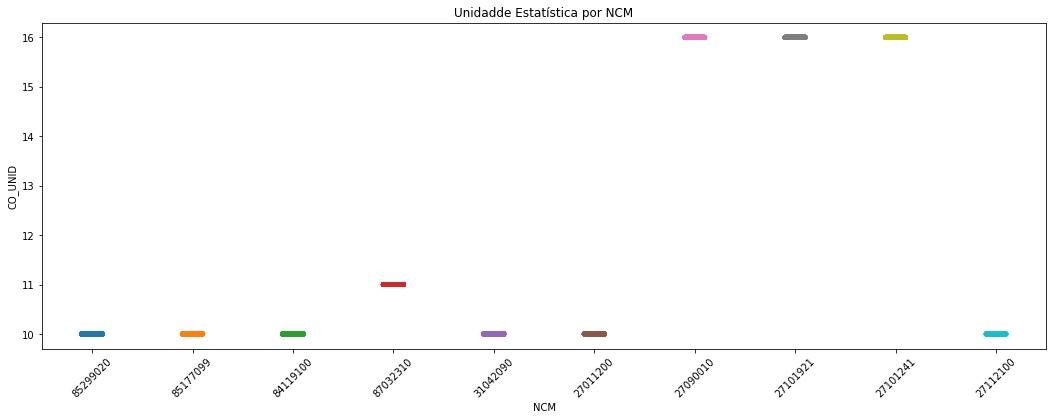

In [12]:
fig, ax = plt.subplots(sharey=False, figsize=(18,6))
plt.title("Unidadde Estatística por NCM")
sns.stripplot(x='NCM', y='CO_UNID', data=df_unidest)
plt.xticks(rotation=45)
plt.show()

In [13]:
df_total.drop(['CO_UNID'],axis=1,inplace=True)

In [125]:
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,COTACAO,FOB_REAIS,VL_SEGURO,VL_FRETE
11,2012,10,85299020 - Outras partes para aparelhos recept...,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,5546,5546,282065,2.029591,572476,640,50113
545,2012,10,85177099 - Outras partes para aparelhos de tel...,Japão,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,250000,16,232825,2.029591,472539,161,698
546,2012,10,85177099 - Outras partes para aparelhos de tel...,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,334281,159,283161,2.029591,574700,83,4927
1238,2012,10,85299020 - Outras partes para aparelhos recept...,Estados Unidos,RJ,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,1,1,1785,2.029591,3622,2,57
1239,2012,10,85299020 - Outras partes para aparelhos recept...,Estados Unidos,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,14863,14863,447108,2.029591,907446,568,245502


### Análise dos Países Exportadores
-----


In [14]:
df = df_total.groupby(['NO_PAIS']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)
df

,NO_PAIS,VL_FOB,porcentagem
0,Estados Unidos,69785998620,2.096943e-01
1,Nigéria,33472537867,1.005789e-01
2,China,25001937598,7.512629e-02
3,Bolívia,21205494361,6.371867e-02
4,Arábia Saudita,18977560814,5.702413e-02
...,...,...,...
135,Tanzânia,274,8.233204e-10
136,Bósnia-Herzegovina,268,8.052915e-10
137,Geórgia,247,7.421903e-10
138,Camarões,234,7.031276e-10


In [15]:
fob_total = df.VL_FOB.sum()
maiores_paises = df.iloc[:30,:]
fob_maiores_paises = maiores_paises.VL_FOB.sum()
perc_paises = fob_maiores_paises/fob_total
print(f'O percentual que esses países representam no valor FOB é de {perc_paises:.1%}')

O percentual que esses países representam no valor FOB é de 95.4%


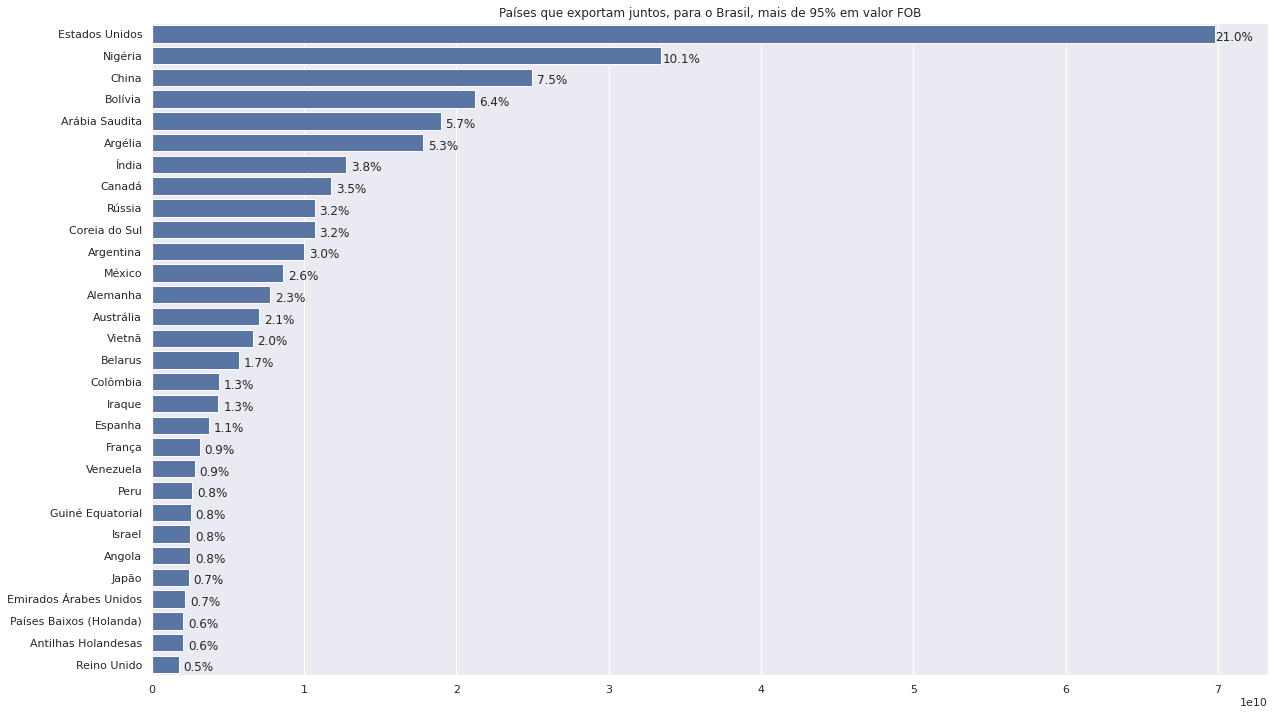

In [16]:
# Visualização dos países que exportam juntos, para o Brasil, mais de 95% em valor FOB

sns.set_theme(style="darkgrid")

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(20, 12))
bar = sns.barplot(x=list(df.VL_FOB)[:30], y=list(df.NO_PAIS)[:30],
            label="Total", color="b")

  
for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (20, -12), 
                   textcoords = 'offset points')

    
ax.set_title("Países que exportam juntos, para o Brasil, mais de 95% em valor FOB")
plt.show()

In [17]:
maiores_paises.NO_PAIS

0              Estados Unidos
1                     Nigéria
2                       China
3                     Bolívia
4              Arábia Saudita
5                     Argélia
6                       Índia
7                      Canadá
8                      Rússia
9               Coreia do Sul
10                  Argentina
11                     México
12                   Alemanha
13                  Austrália
14                     Vietnã
15                    Belarus
16                   Colômbia
17                     Iraque
18                    Espanha
19                     França
20                  Venezuela
21                       Peru
22           Guiné Equatorial
23                     Israel
24                     Angola
25                      Japão
26     Emirados Árabes Unidos
27    Países Baixos (Holanda)
28        Antilhas Holandesas
29                Reino Unido
Name: NO_PAIS, dtype: object

In [18]:
df_total.NO_PAIS = df_total.NO_PAIS.apply(lambda x : 'OUTROS' if x not in list(maiores_paises.NO_PAIS) else x)

In [19]:
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,COTACAO,FOB_REAIS,VL_SEGURO,VL_FRETE
11,2012,10,85299020 - Outras partes para aparelhos recept...,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,5546,5546,282065,2.029591,572476,640,50113
545,2012,10,85177099 - Outras partes para aparelhos de tel...,Japão,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,250000,16,232825,2.029591,472539,161,698
546,2012,10,85177099 - Outras partes para aparelhos de tel...,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,334281,159,283161,2.029591,574700,83,4927
1238,2012,10,85299020 - Outras partes para aparelhos recept...,Estados Unidos,RJ,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,1,1,1785,2.029591,3622,2,57
1239,2012,10,85299020 - Outras partes para aparelhos recept...,Estados Unidos,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,14863,14863,447108,2.029591,907446,568,245502


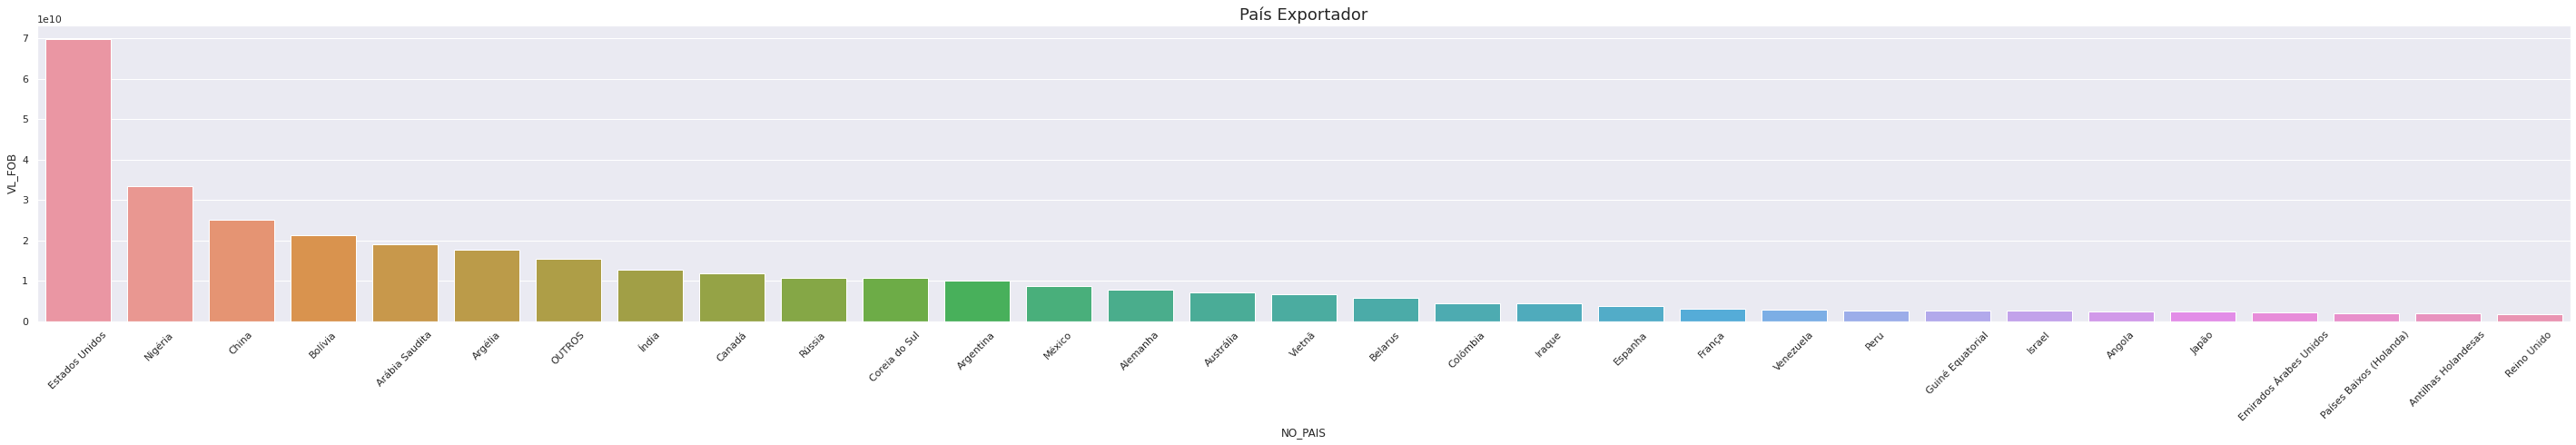

In [20]:
df = df_total.groupby(['NO_PAIS']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(50,6))
sns.barplot(x=df['NO_PAIS'], y = df['VL_FOB'])
plt.title("País Exportador", fontsize=18)
#for i,p in enumerate(ax.patches):
#    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
#                   (p.get_x() + p.get_width() / 2., p.get_height()), 
#                   ha = 'center', va = 'center', 
#                   xytext = (0, 9), 
#                   textcoords = 'offset points')
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE.png',bbox_inches='tight')

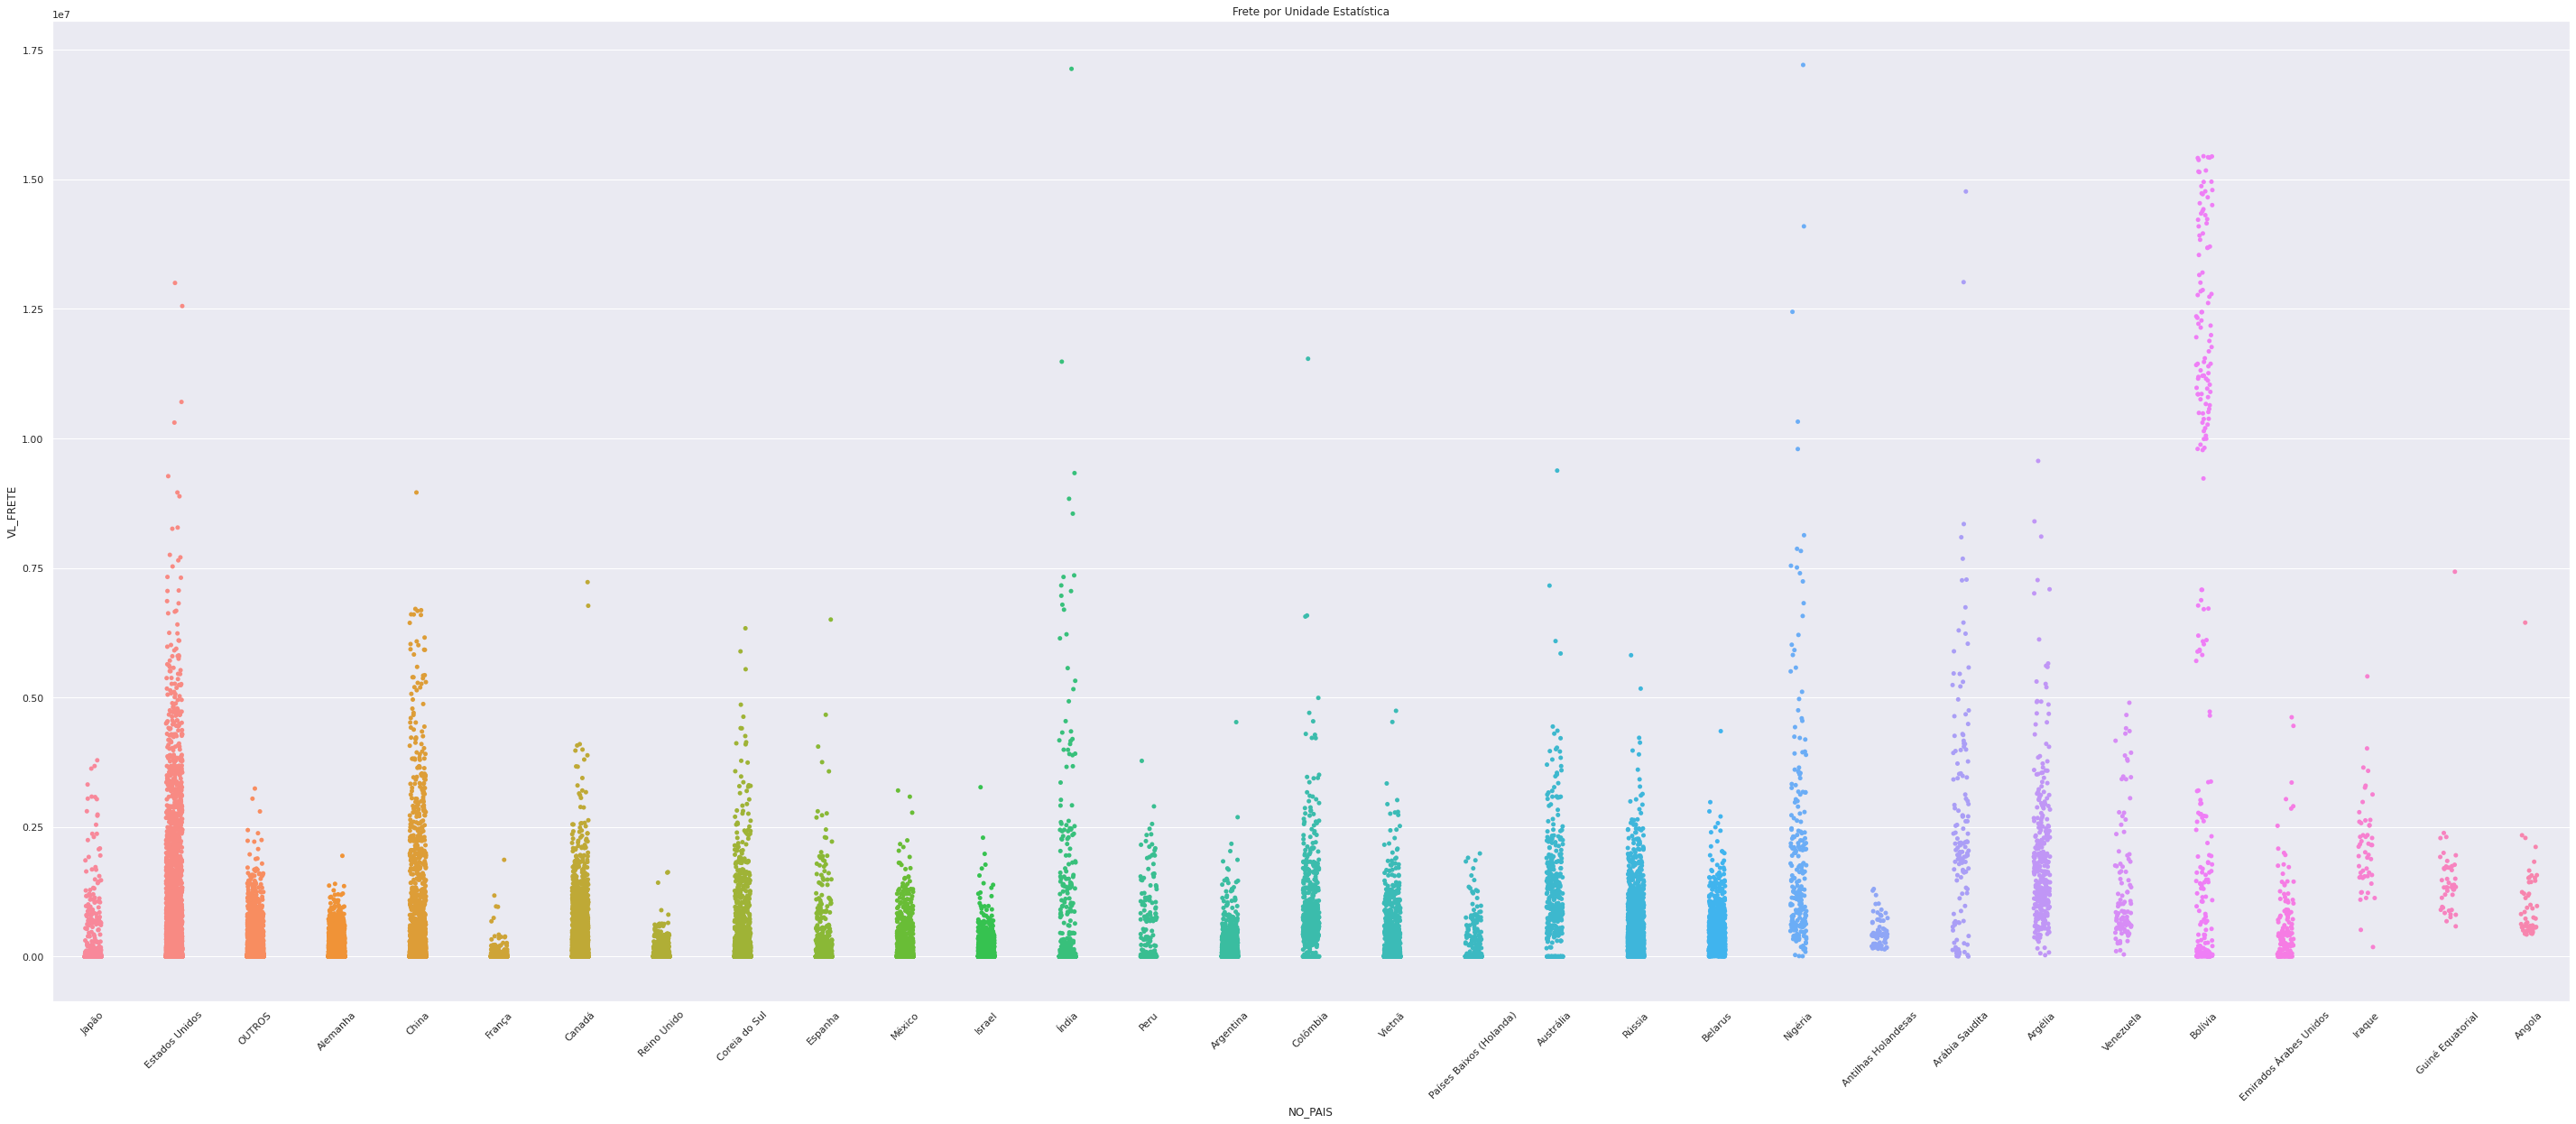

In [21]:
fig, ax1 = plt.subplots(sharey=False, figsize=(50,20))
plt.title("Frete por Unidade Estatística")
sns.stripplot(x='NO_PAIS', y='VL_FRETE', data=df_total, ax=ax1)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

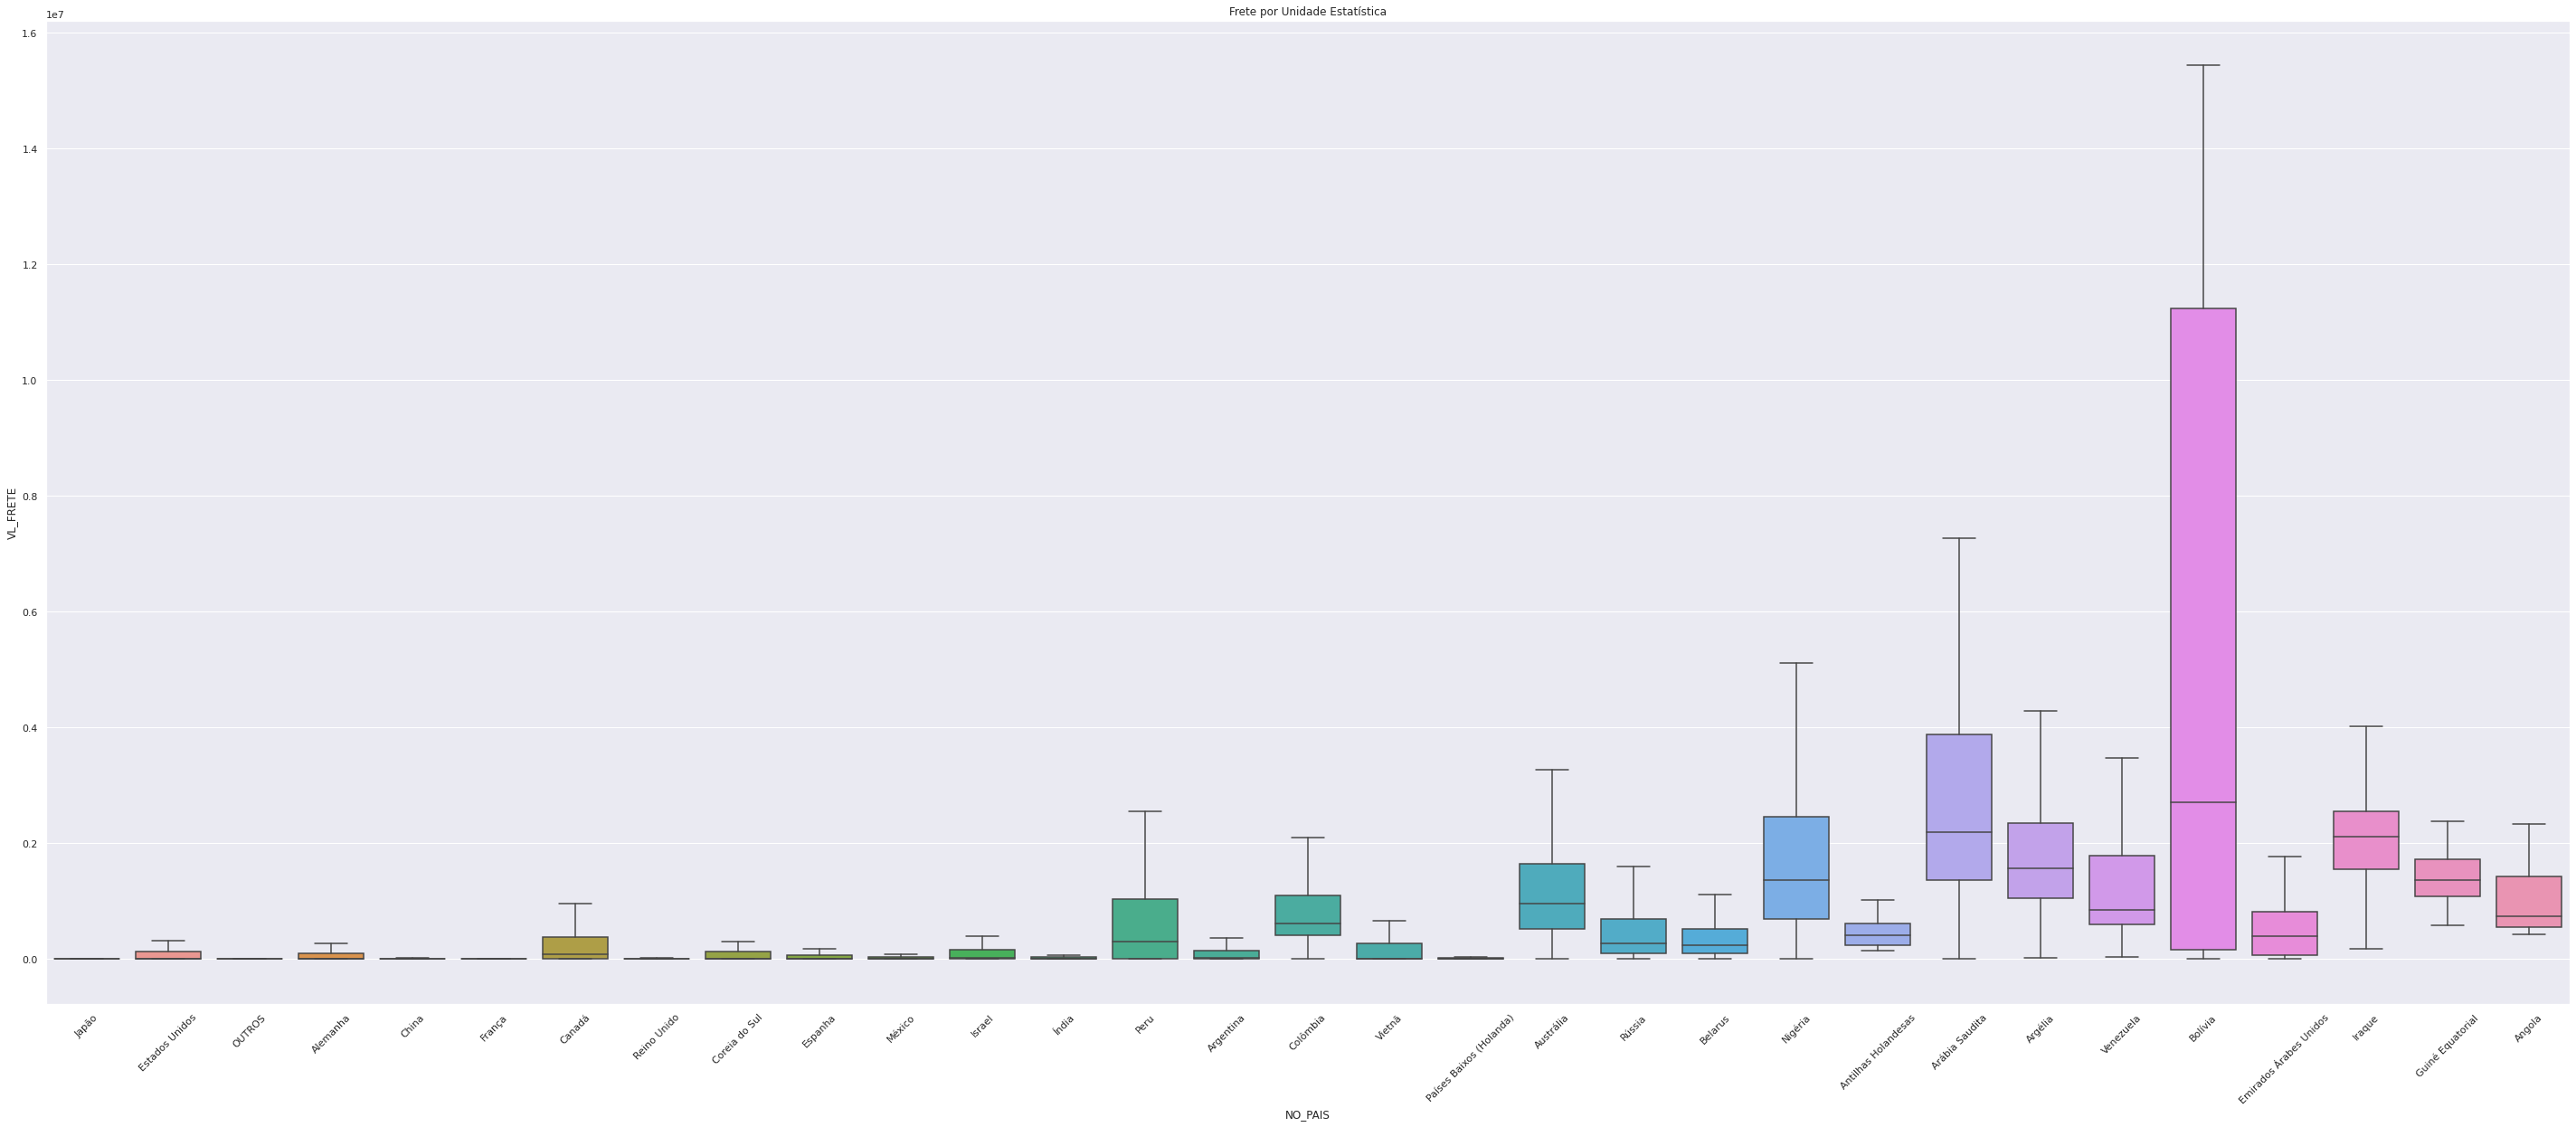

In [22]:
fig, ax2 = plt.subplots(sharey=False, figsize=(50,20))
plt.title("Frete por Unidade Estatística")
sns.boxplot(x='NO_PAIS', y='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise dos Estados de Destino das Mercadorias
-----


In [23]:
df = df_total.groupby(['SG_UF_NCM']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)
df

,SG_UF_NCM,VL_FOB,porcentagem
0,SP,70317981571,2.112928e-01
1,RJ,51032296188,1.533428e-01
2,RS,36209588514,1.088033e-01
3,AM,30037000086,9.025575e-02
4,PR,24492634178,7.359593e-02
5,MA,23437772625,7.042626e-02
6,BA,22860371796,6.869128e-02
7,MS,21199099673,6.369946e-02
8,ES,11901430636,3.576164e-02
9,MG,11045103247,3.318854e-02


In [24]:
fob_total = df.VL_FOB.sum()
maiores_destinos = df.iloc[:12,:]
fob_maiores_destinos = maiores_destinos.VL_FOB.sum()
perc_destinos = fob_maiores_destinos/fob_total
print(f'O percentual que esses destinos representam no valor FOB é de {perc_destinos:.1%}')

O percentual que esses destinos representam no valor FOB é de 95.5%


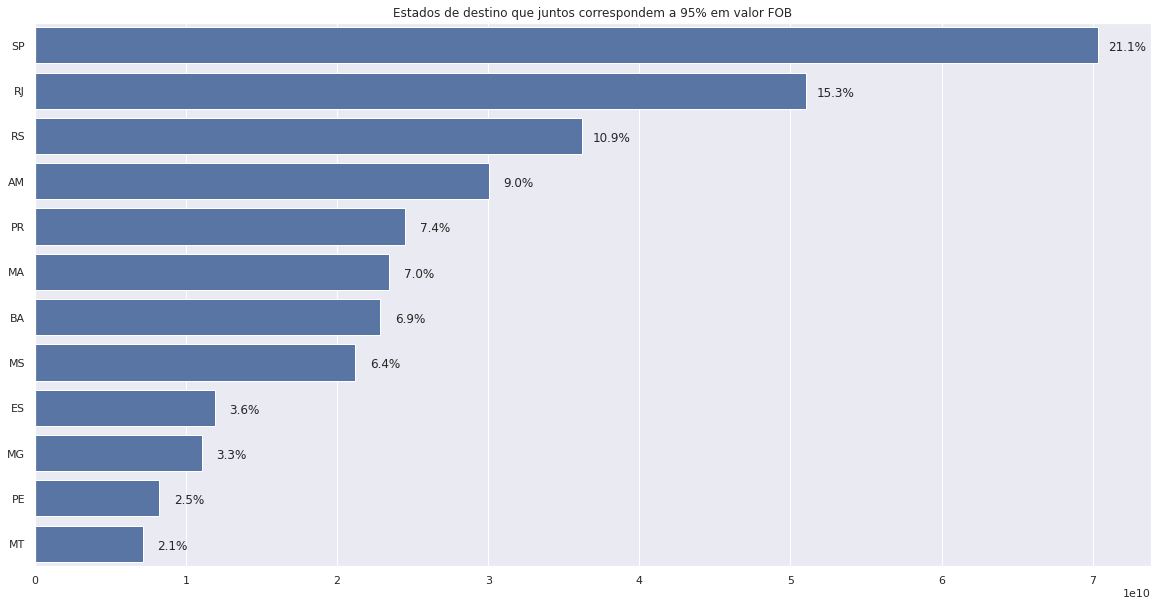

In [25]:
# Visualização dos estados de destino que juntos correspondem a 95% em valor FOB

sns.set_theme(style="darkgrid")

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(20, 10))
bar = sns.barplot(x=list(df.VL_FOB)[:12], y=list(df.SG_UF_NCM)[:12],
            label="Total", color="b")

for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (30, -20), 
                   textcoords = 'offset points')   

ax.set_title("Estados de destino que juntos correspondem a 95% em valor FOB")
plt.show()

In [26]:
maiores_destinos.SG_UF_NCM

0     SP
1     RJ
2     RS
3     AM
4     PR
5     MA
6     BA
7     MS
8     ES
9     MG
10    PE
11    MT
Name: SG_UF_NCM, dtype: object

In [27]:
df_total.SG_UF_NCM = df_total.SG_UF_NCM.apply(lambda x : 'OUTROS' if x not in list(maiores_destinos.SG_UF_NCM) else x)

In [28]:
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,COTACAO,FOB_REAIS,VL_SEGURO,VL_FRETE
11,2012,10,85299020 - Outras partes para aparelhos recept...,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,5546,5546,282065,2.029591,572476,640,50113
545,2012,10,85177099 - Outras partes para aparelhos de tel...,Japão,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,250000,16,232825,2.029591,472539,161,698
546,2012,10,85177099 - Outras partes para aparelhos de tel...,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,334281,159,283161,2.029591,574700,83,4927
1238,2012,10,85299020 - Outras partes para aparelhos recept...,Estados Unidos,RJ,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,1,1,1785,2.029591,3622,2,57
1239,2012,10,85299020 - Outras partes para aparelhos recept...,Estados Unidos,OUTROS,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,14863,14863,447108,2.029591,907446,568,245502


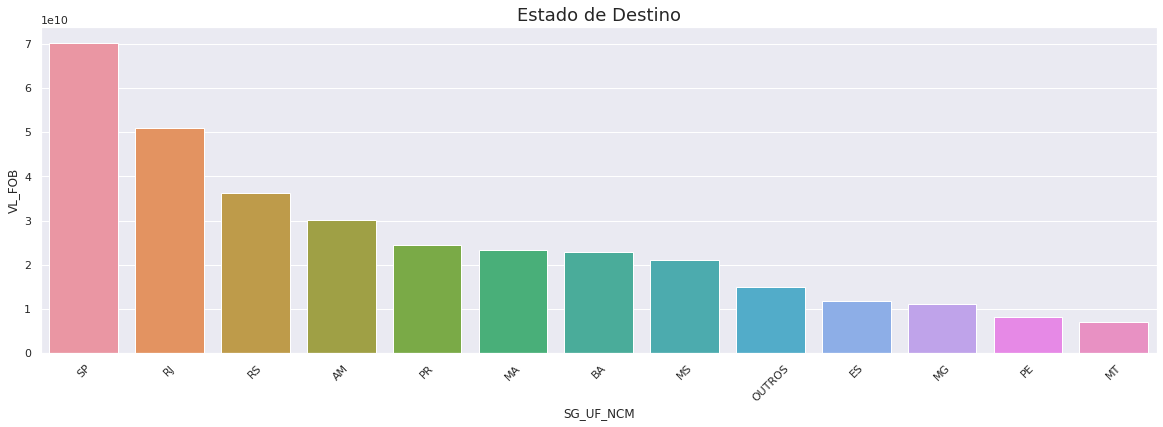

In [29]:
df = df_total.groupby(['SG_UF_NCM']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(20,6))
sns.barplot(x=df['SG_UF_NCM'], y = df['VL_FOB'])
plt.title("Estado de Destino", fontsize=18)
#for i,p in enumerate(ax.patches):
#    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
#                   (p.get_x() + p.get_width() / 2., p.get_height()), 
#                   ha = 'center', va = 'center', 
#                   xytext = (0, 9), 
#                   textcoords = 'offset points')
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE.png',bbox_inches='tight')

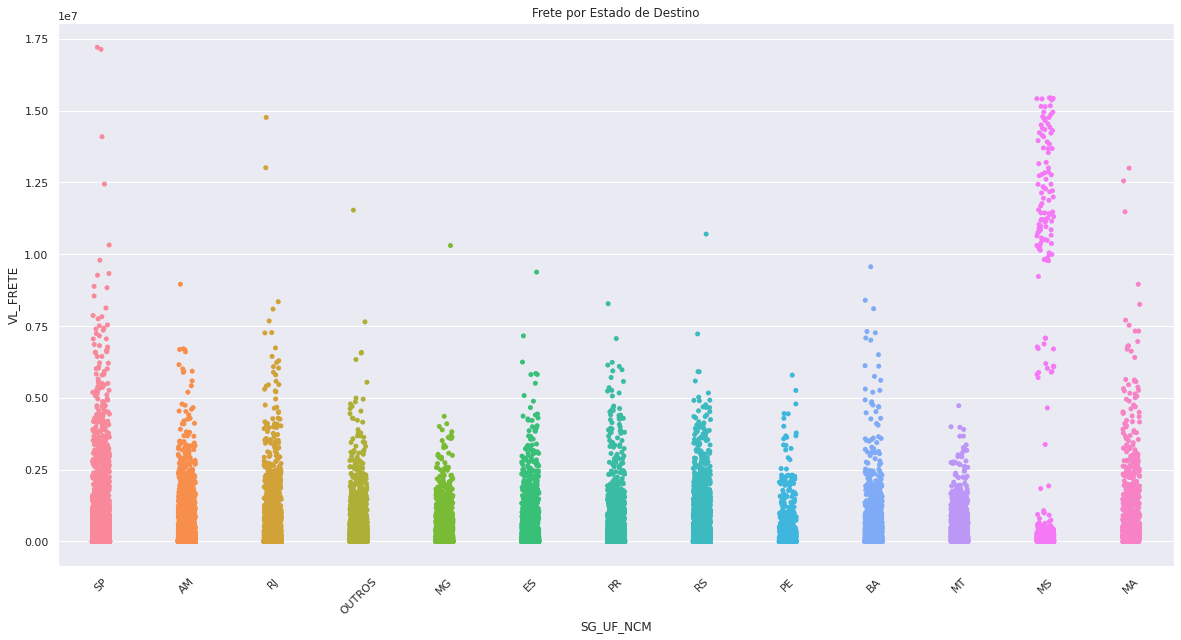

In [30]:
fig, ax1 = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Frete por Estado de Destino")
sns.stripplot(x='SG_UF_NCM', y='VL_FRETE', data=df_total, ax=ax1)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

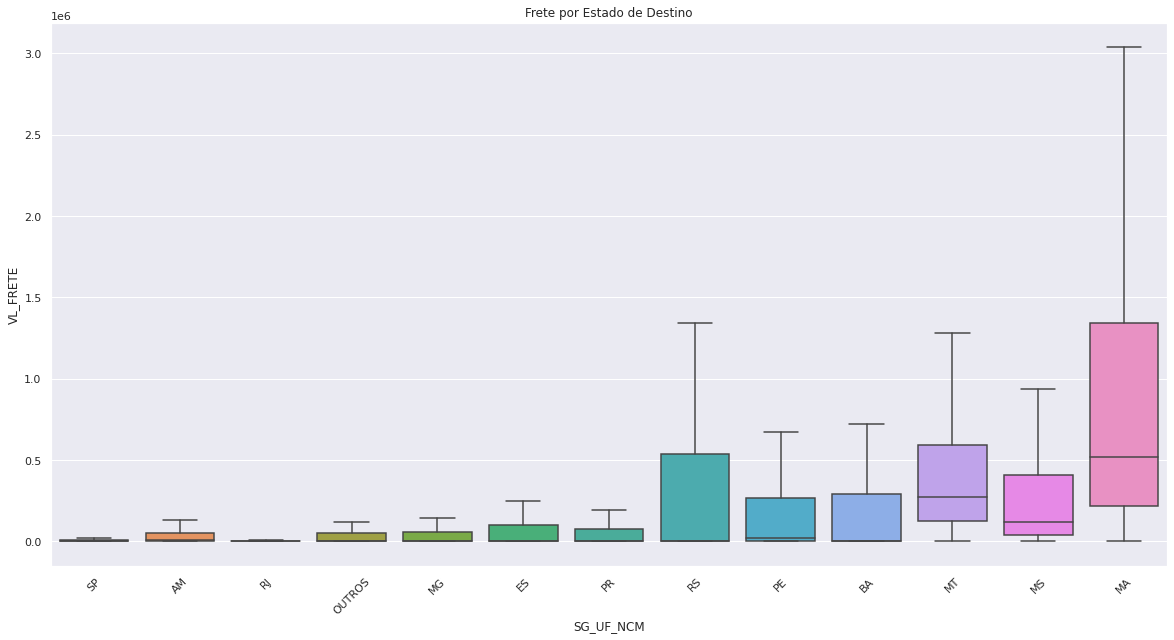

In [31]:
fig, ax2 = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Frete por Estado de Destino")
sns.boxplot(x='SG_UF_NCM', y='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise da Via de Transporte
-----


In [32]:
df = df_total.groupby(['NO_VIA']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)
df

,NO_VIA,VL_FOB,porcentagem
0,MARITIMA,264878791899,7.959128e-01
1,AEREA,44865214274,1.348118e-01
2,CONDUTO/REDE DE TRANSMISSAO,21528748748,6.468999e-02
3,RODOVIARIA,1468368243,4.412181e-03
4,FLUVIAL,33657215,1.011338e-04
5,MEIOS PROPRIOS,13347082,4.010556e-05
6,ENTRADA/SAIDA FICTA,7923515,2.380873e-05
7,FERROVIARIA,2686111,8.071277e-06
8,POSTAL,20170,6.060720e-08


In [33]:
fob_total = df.VL_FOB.sum()
maiores_vias = df.iloc[:3,:]
fob_maiores_vias = maiores_vias.VL_FOB.sum()
perc_vias = fob_maiores_vias/fob_total
print(f'O percentual que essas vias de transporte representam no valor FOB é de {perc_vias:.1%}')

O percentual que essas vias de transporte representam no valor FOB é de 99.5%


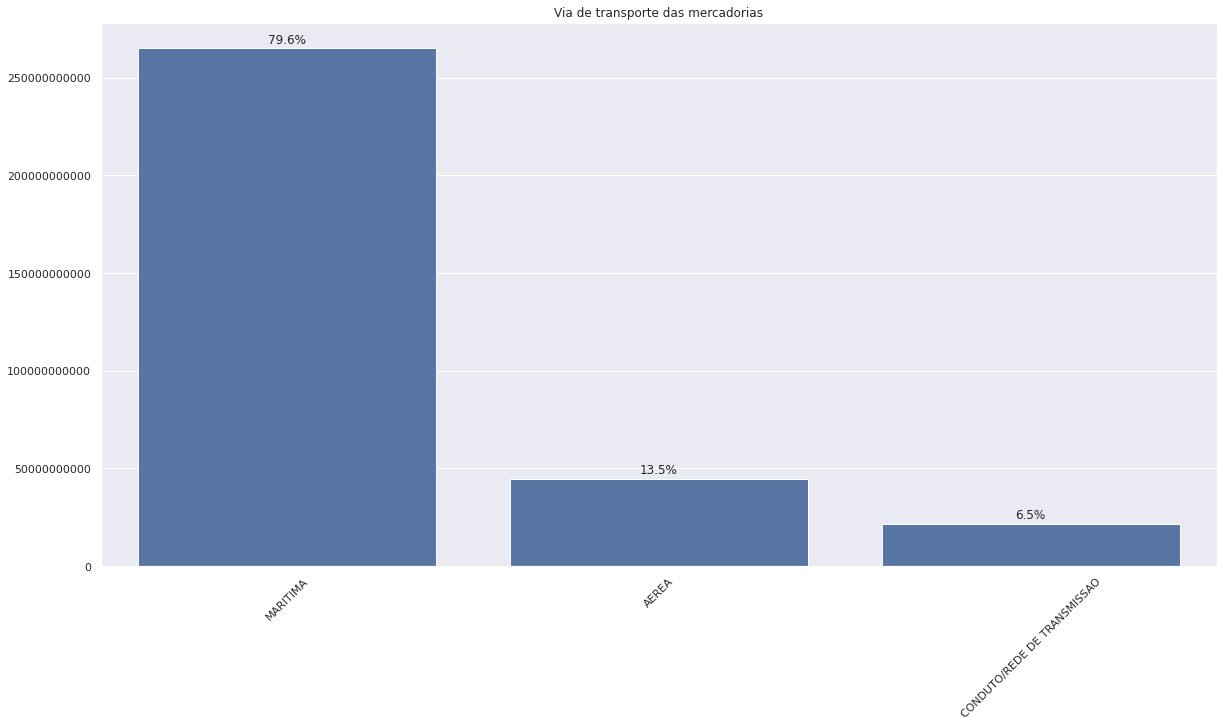

In [34]:
# Visualização das vias de trasponrte que juntas representam mais de 95% em valor FOB

sns.set_theme(style="darkgrid")

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(20, 10))
bar = sns.barplot(y=list(df.VL_FOB)[:3], x=list(df.NO_VIA)[:3],
            label="Total", color="b")

for i,p in enumerate(bar.patches):
    bar.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    

ax.set_title("Via de transporte das mercadorias")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: int(y)))
plt.xticks(rotation=45)
plt.show()



In [35]:
maiores_vias.NO_VIA

0                       MARITIMA
1                          AEREA
2    CONDUTO/REDE DE TRANSMISSAO
Name: NO_VIA, dtype: object

In [36]:
df_total.NO_VIA = df_total.NO_VIA.apply(lambda x : 'OUTROS' if x not in list(maiores_vias.NO_VIA) else x)

In [37]:
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,COTACAO,FOB_REAIS,VL_SEGURO,VL_FRETE
11,2012,10,85299020 - Outras partes para aparelhos recept...,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,5546,5546,282065,2.029591,572476,640,50113
545,2012,10,85177099 - Outras partes para aparelhos de tel...,Japão,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,250000,16,232825,2.029591,472539,161,698
546,2012,10,85177099 - Outras partes para aparelhos de tel...,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,334281,159,283161,2.029591,574700,83,4927
1238,2012,10,85299020 - Outras partes para aparelhos recept...,Estados Unidos,RJ,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,1,1,1785,2.029591,3622,2,57
1239,2012,10,85299020 - Outras partes para aparelhos recept...,Estados Unidos,OUTROS,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,14863,14863,447108,2.029591,907446,568,245502


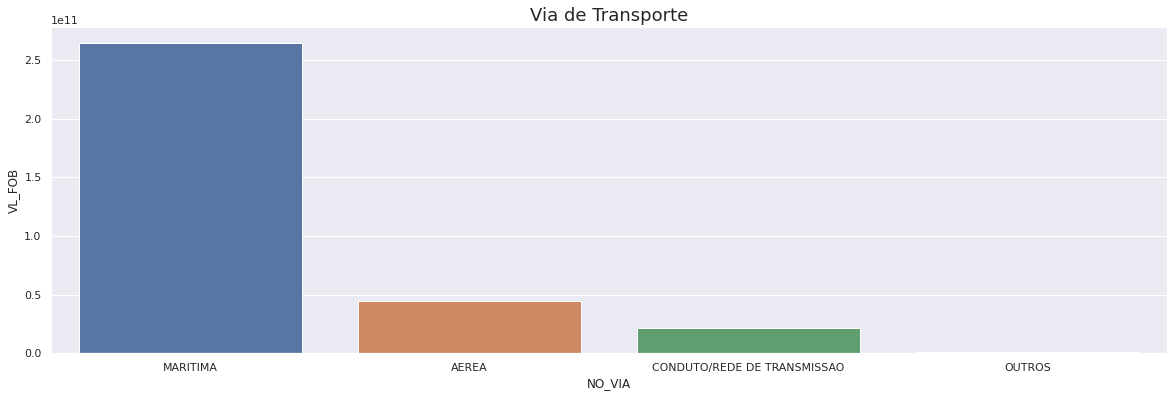

In [38]:
df = df_total.groupby(['NO_VIA']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(20,6))
sns.barplot(x=df['NO_VIA'], y = df['VL_FOB'])
plt.title("Via de Transporte", fontsize=18)
#for i,p in enumerate(ax.patches):
#    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
#                   (p.get_x() + p.get_width() / 2., p.get_height()), 
#                   ha = 'center', va = 'center', 
#                   xytext = (0, 9), 
#                   textcoords = 'offset points')
#plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE.png',bbox_inches='tight')

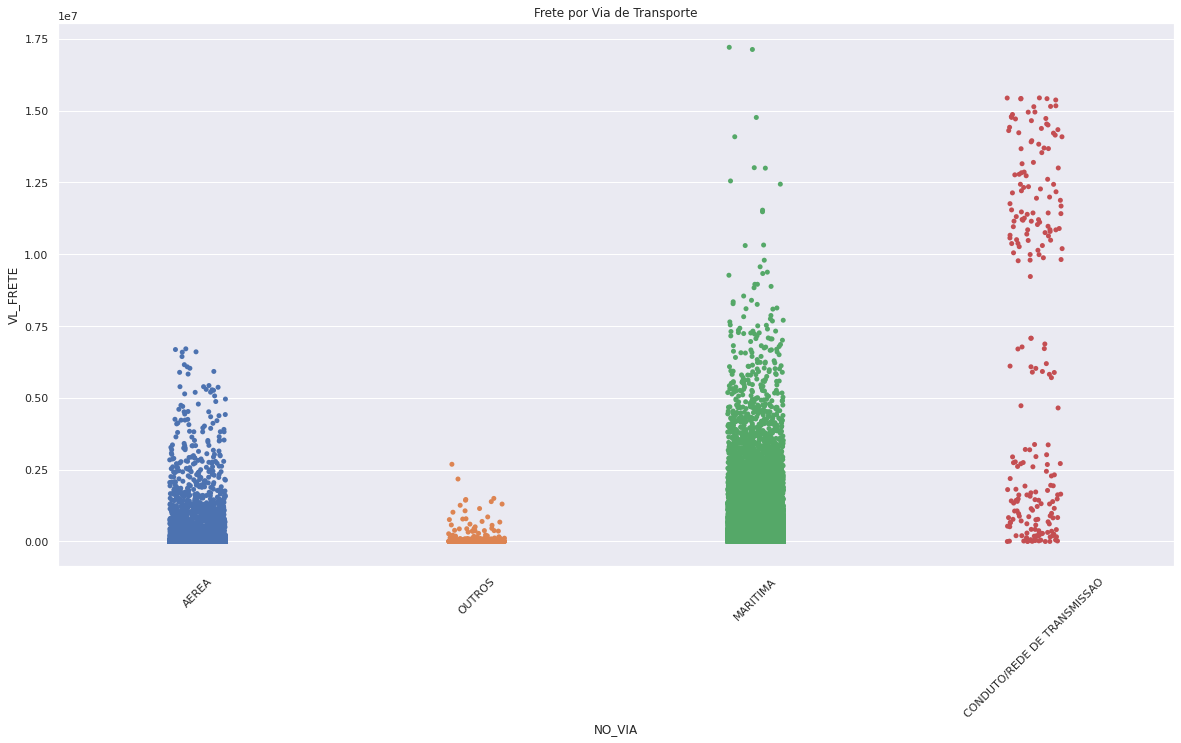

In [39]:
fig, ax1 = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Frete por Via de Transporte")
sns.stripplot(x='NO_VIA', y='VL_FRETE', data=df_total, ax=ax1)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

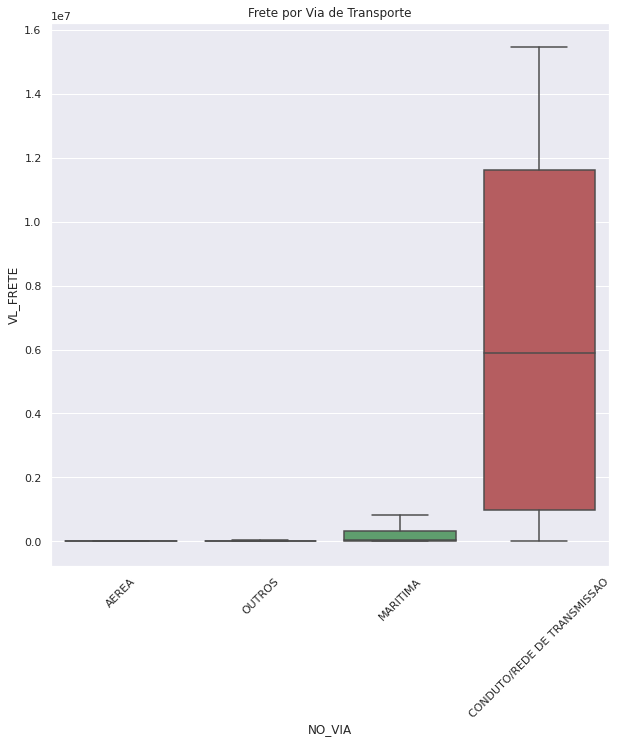

In [40]:
fig, ax2 = plt.subplots(sharey=False, figsize=(10,10))
plt.title("Frete por Via de Transporte")
sns.boxplot(x='NO_VIA', y='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise da URF de Desembaraço


In [41]:
df = df_total.groupby(['NO_URF']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)
df

,NO_URF,VL_FOB,porcentagem
0,0812051 - SAO SEBASTIAO,38348006571,1.152288e-01
1,0717800 - PORTO DE ITAGUAI,27818261260,8.358884e-02
2,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,25104004958,7.543299e-02
3,0917800 - PORTO DE PARANAGUA,22014680038,6.615013e-02
4,1015400 - PORTO ALEGRE,21395951416,6.429096e-02
...,...,...,...
86,1010252 - JAGUARAO,4324,1.299284e-08
87,1015600 - SANTANA DO LIVRAMENTO,3234,9.717584e-09
88,0230154 - Assis Brasil,1529,4.594368e-09
89,1017900 - ALF - SANTANA DO LIVRAMENTO,1120,3.365397e-09


In [42]:
fob_total = df.VL_FOB.sum()
maiores_urf = df.iloc[:24,:]
fob_maiores_urf = maiores_urf.VL_FOB.sum()
perc_urf = fob_maiores_urf/fob_total
print(f'O percentual que essas unidades representam no valor FOB é de {perc_urf:.1%}')

O percentual que essas unidades representam no valor FOB é de 95.7%


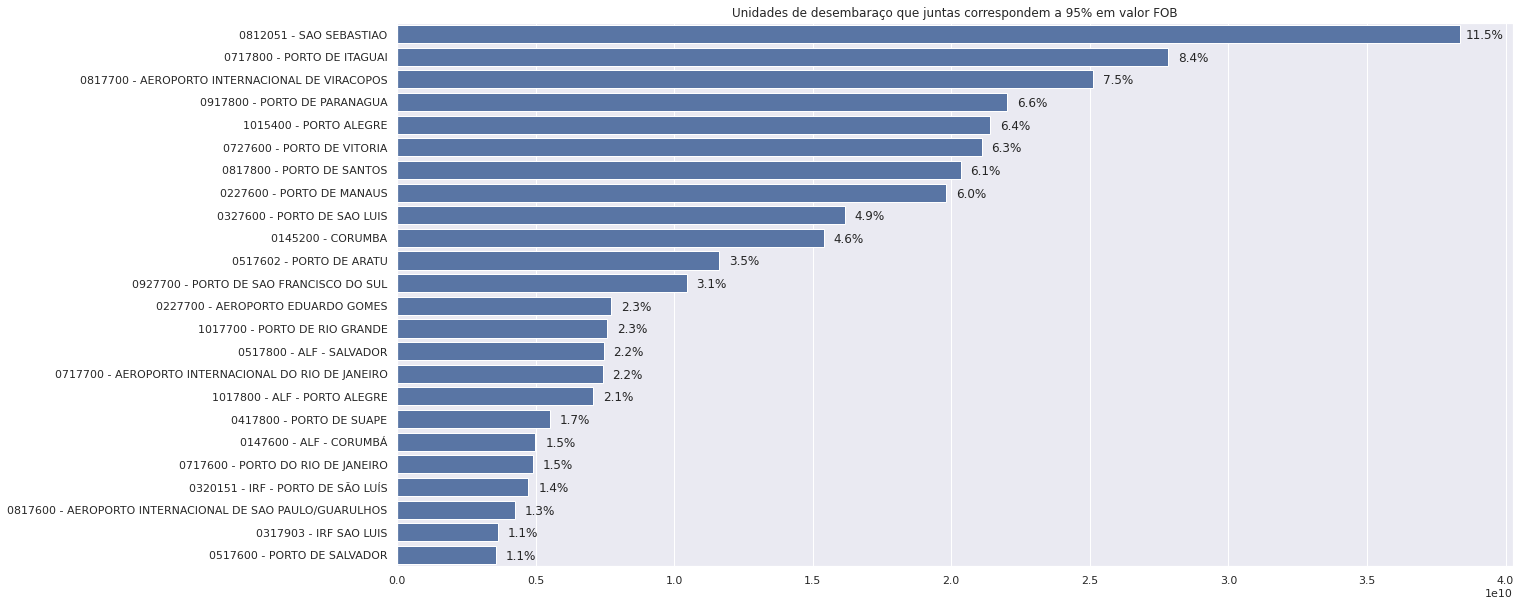

In [43]:
# Visualização dos estados de destino que juntos correspondem a 95% em valor FOB

sns.set_theme(style="darkgrid")

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(20, 10))
bar = sns.barplot(x=list(df.VL_FOB)[:24], y=list(df.NO_URF)[:24],
            label="Total", color="b")

for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (25, -10), 
                   textcoords = 'offset points')   

ax.set_title("Unidades de desembaraço que juntas correspondem a 95% em valor FOB")
plt.show()


In [44]:
maiores_urf.NO_URF

0                               0812051 - SAO SEBASTIAO
1                            0717800 - PORTO DE ITAGUAI
2        0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS
3                          0917800 - PORTO DE PARANAGUA
4                                1015400 - PORTO ALEGRE
5                            0727600 - PORTO DE VITORIA
6                             0817800 - PORTO DE SANTOS
7                             0227600 - PORTO DE MANAUS
8                           0327600 - PORTO DE SAO LUIS
9                                     0145200 - CORUMBA
10                             0517602 - PORTO DE ARATU
11              0927700 - PORTO DE SAO FRANCISCO DO SUL
12                    0227700 - AEROPORTO EDUARDO GOMES
13                        1017700 - PORTO DE RIO GRANDE
14                             0517800 - ALF - SALVADOR
15    0717700 - AEROPORTO INTERNACIONAL DO RIO DE JA...
16                         1017800 - ALF - PORTO ALEGRE
17                             0417800 - PORTO D

In [45]:
df_total.NO_URF = df_total.NO_URF.apply(lambda x : 'OUTROS' if x not in list(maiores_urf.NO_URF) else x)

In [46]:
df_total

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,COTACAO,FOB_REAIS,VL_SEGURO,VL_FRETE
11,2012,10,85299020 - Outras partes para aparelhos recept...,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,5546,5546,282065,2.029591,572476,640,50113
545,2012,10,85177099 - Outras partes para aparelhos de tel...,Japão,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,250000,16,232825,2.029591,472539,161,698
546,2012,10,85177099 - Outras partes para aparelhos de tel...,Japão,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,334281,159,283161,2.029591,574700,83,4927
1238,2012,10,85299020 - Outras partes para aparelhos recept...,Estados Unidos,RJ,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,1,1,1785,2.029591,3622,2,57
1239,2012,10,85299020 - Outras partes para aparelhos recept...,Estados Unidos,OUTROS,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,14863,14863,447108,2.029591,907446,568,245502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18689495,2017,7,27090010 - Óleos brutos de petróleo,OUTROS,RS,MARITIMA,1015400 - PORTO ALEGRE,95830,71211513,25201076,3.200524,80656643,0,1283000
18689496,2017,7,27101921 - Gasóleo (óleo diesel),Estados Unidos,RJ,MARITIMA,OUTROS,12021,10260493,4568995,3.200524,14623177,0,323036
18689498,2017,7,27112100 - Gás natural no estado gasoso,Bolívia,MS,CONDUTO/REDE DE TRANSMISSAO,0145200 - CORUMBA,363662702,363662702,66392477,3.200524,212490703,0,9774146
18689500,2017,7,27112100 - Gás natural no estado gasoso,Bolívia,MT,CONDUTO/REDE DE TRANSMISSAO,OUTROS,1882,1882,519416,3.200524,1662403,0,96006


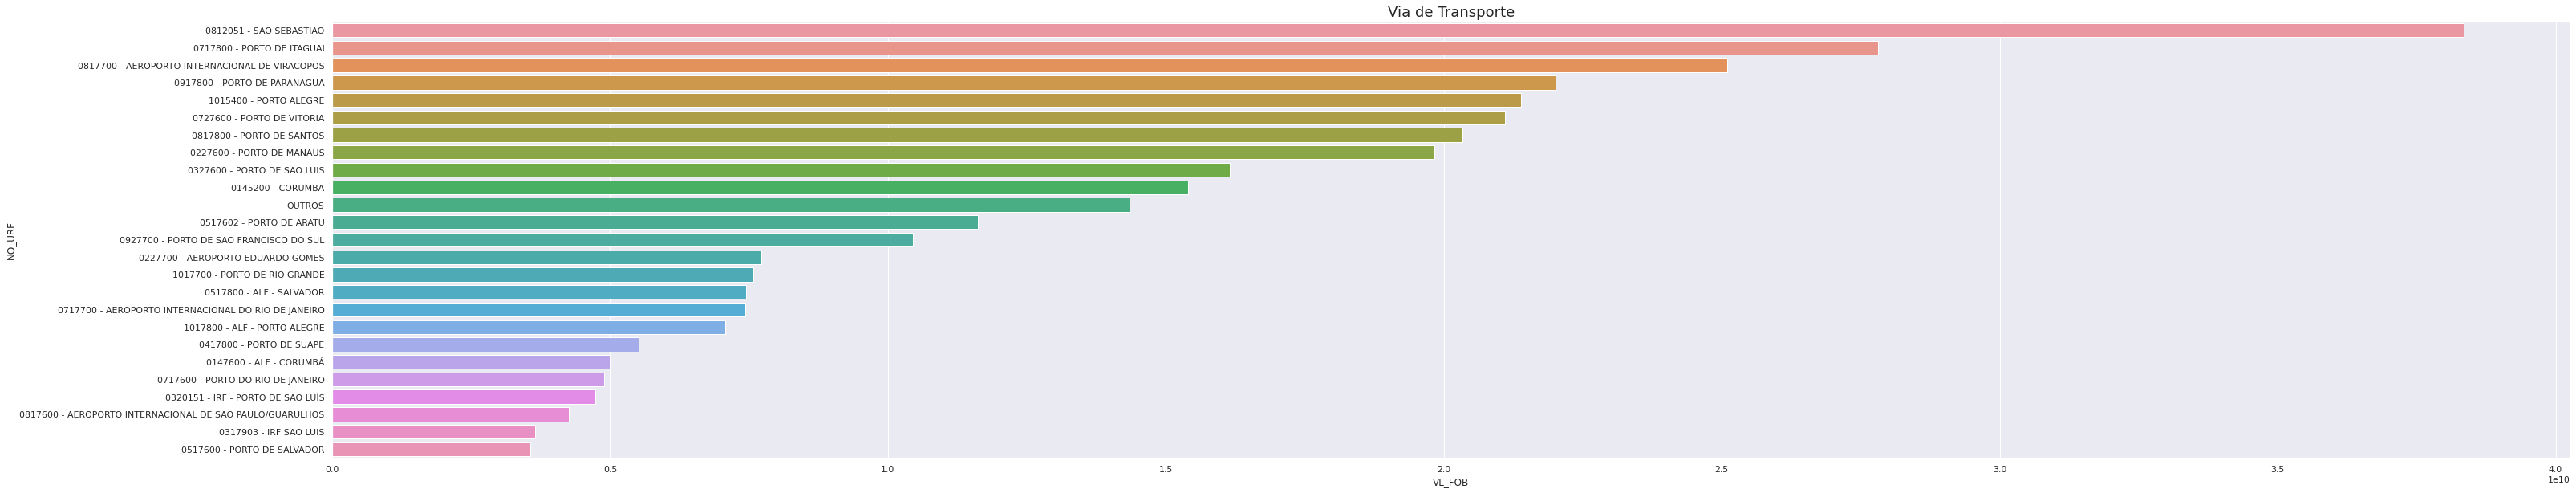

In [47]:
df = df_total.groupby(['NO_URF']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(50,10))
sns.barplot(y=df['NO_URF'], x = df['VL_FOB'])
plt.title("Via de Transporte", fontsize=18)
#for i,p in enumerate(ax.patches):
#    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
#                   (p.get_x() + p.get_width() / 2., p.get_height()), 
#                   ha = 'center', va = 'center', 
#                   xytext = (0, 9), 
#                   textcoords = 'offset points')
#plt.xticks(rotation=80)
plt.show()
#plt.savefig('imagens/tipoCE.png',bbox_inches='tight')

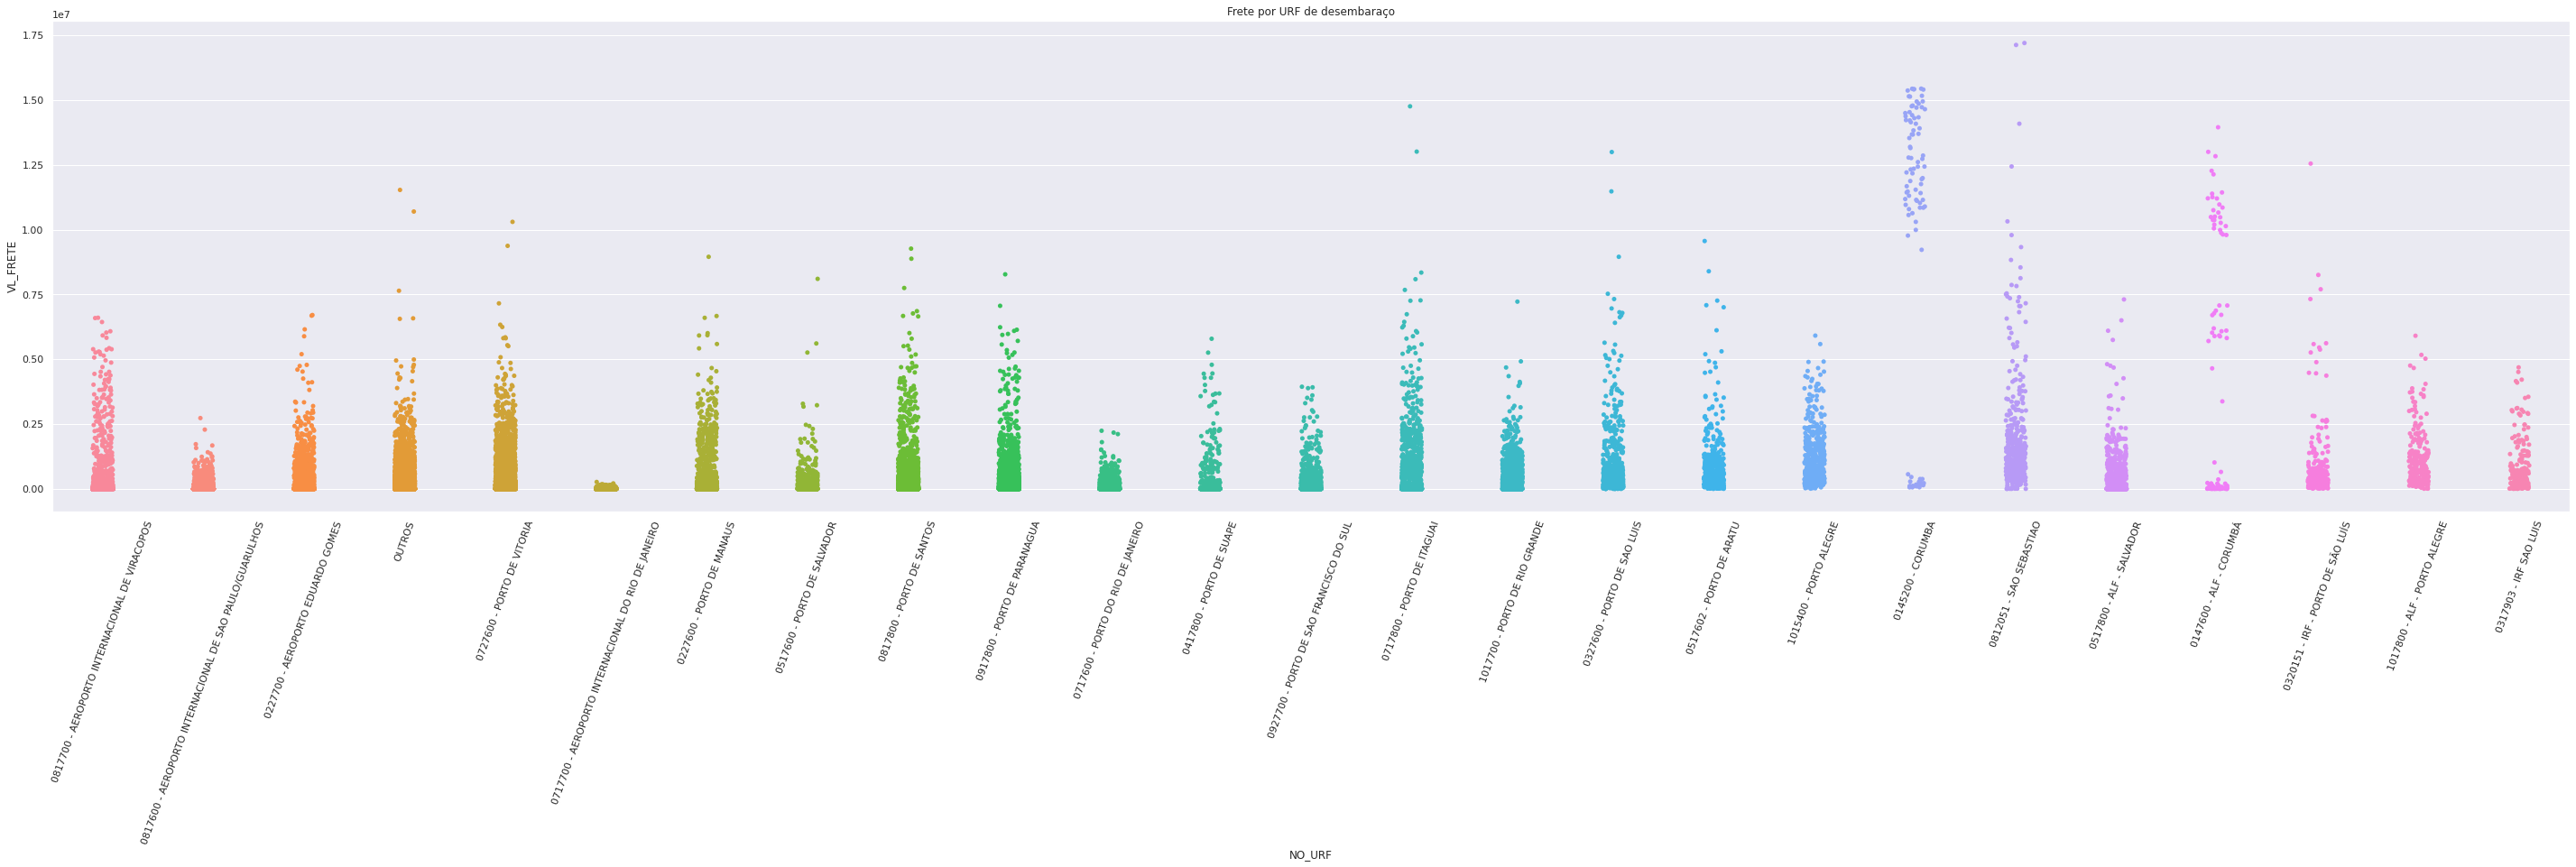

In [48]:
fig, ax1 = plt.subplots(sharey=False, figsize=(50,10))
plt.title("Frete por URF de desembaraço")
sns.stripplot(x='NO_URF', y='VL_FRETE', data=df_total, ax=ax1)
plt.xticks(rotation=70)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

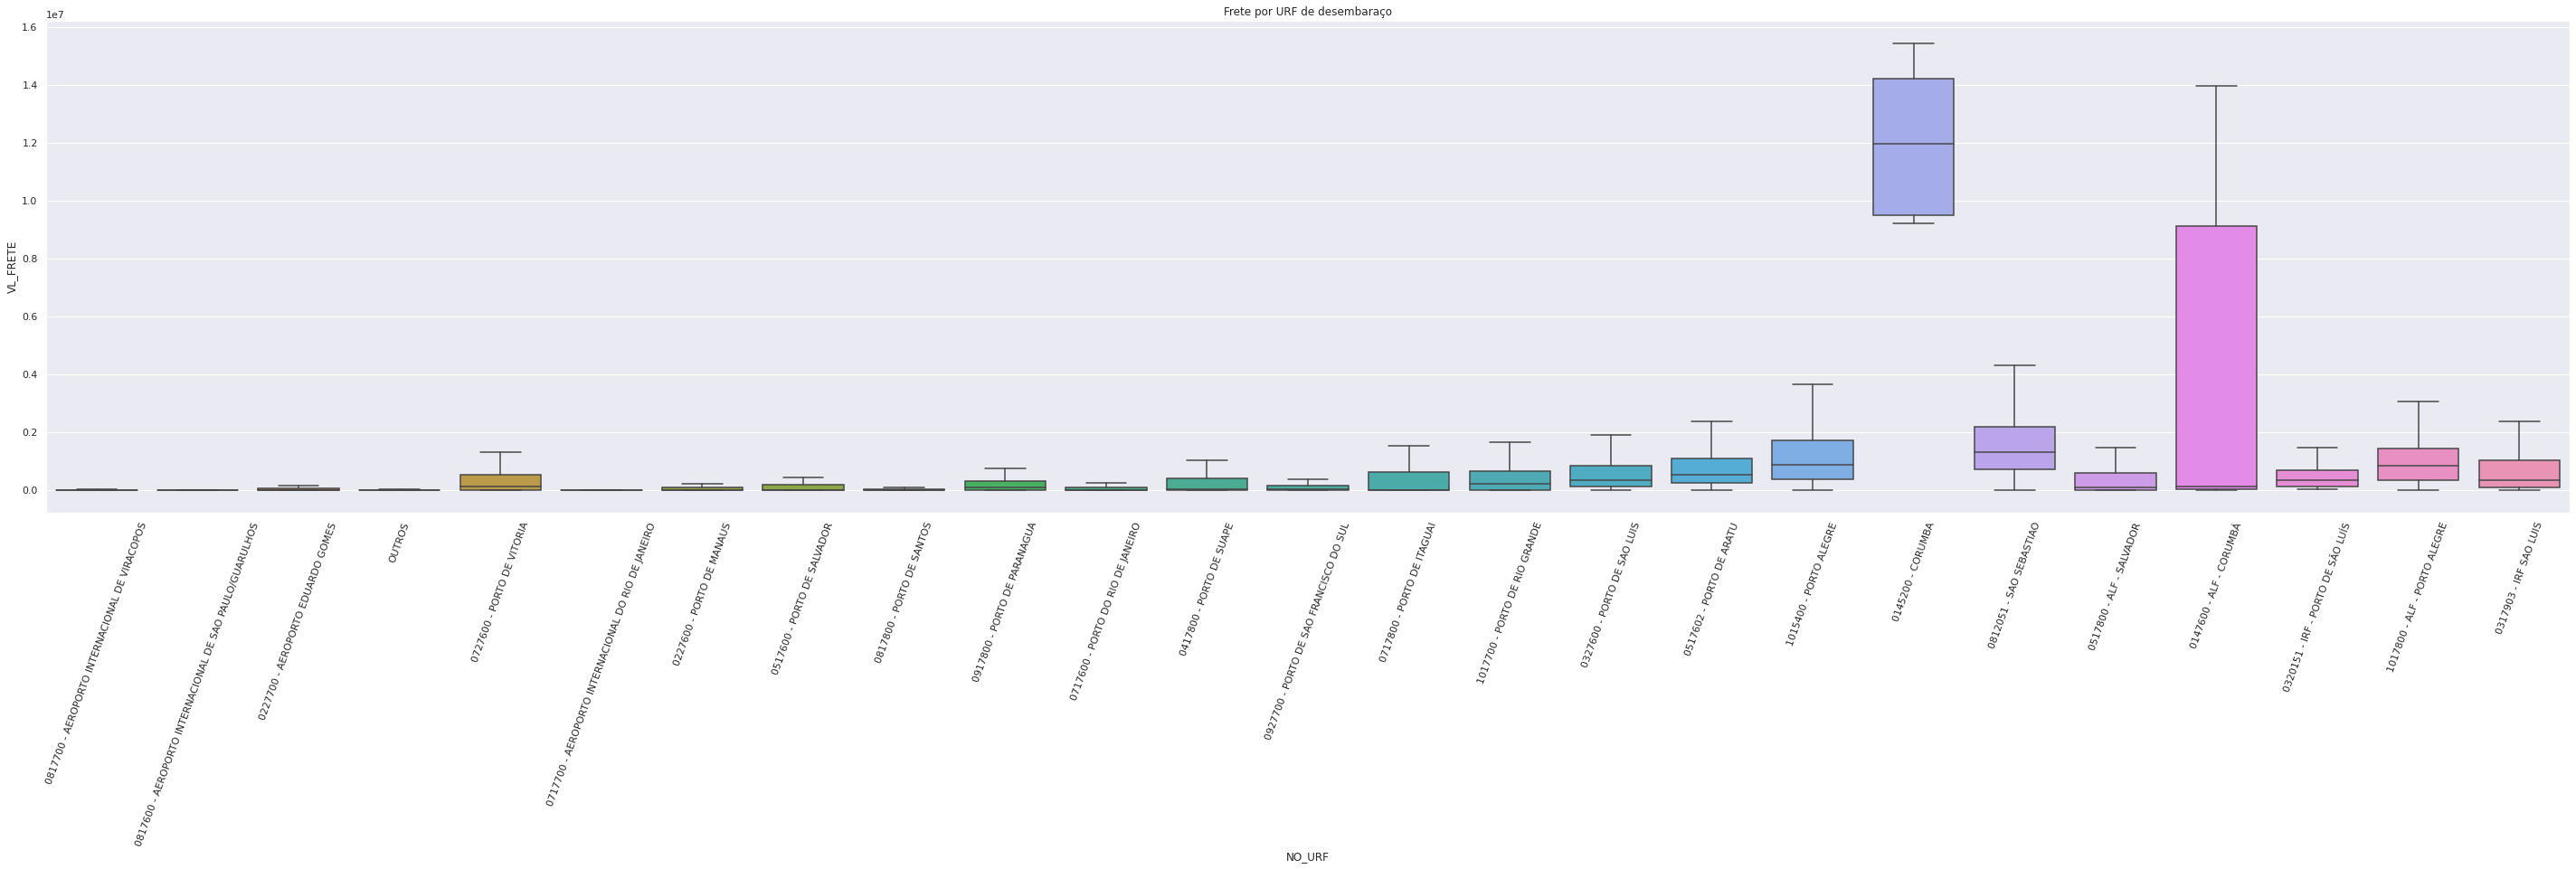

In [49]:
fig, ax2 = plt.subplots(sharey=False, figsize=(50,10))
plt.title("Frete por URF de desembaraço")
sns.boxplot(x='NO_URF', y='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
plt.xticks(rotation=70)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise Variáveis quantitativas


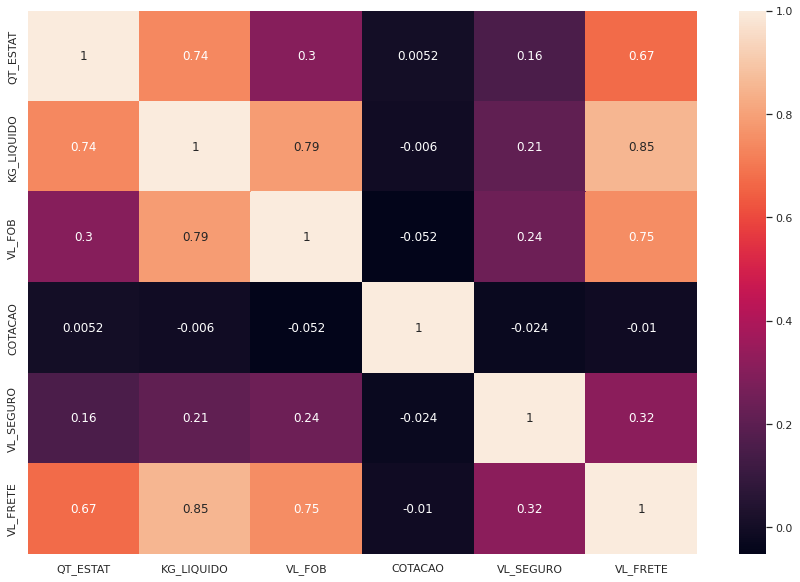

In [50]:
df_quantitativas = df_total[['QT_ESTAT','KG_LIQUIDO','VL_FOB','COTACAO','VL_SEGURO','VL_FRETE']]

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(15, 10))

    ax = sns.heatmap(df_quantitativas.corr(),annot=True)

In [51]:
df_quantitativas2 = df_total[['KG_LIQUIDO','VL_FOB','VL_FRETE']]
df_quantitativas2

,KG_LIQUIDO,VL_FOB,VL_FRETE
11,5546,282065,50113
545,16,232825,698
546,159,283161,4927
1238,1,1785,57
1239,14863,447108,245502
...,...,...,...
18689495,71211513,25201076,1283000
18689496,10260493,4568995,323036
18689498,363662702,66392477,9774146
18689500,1882,519416,96006


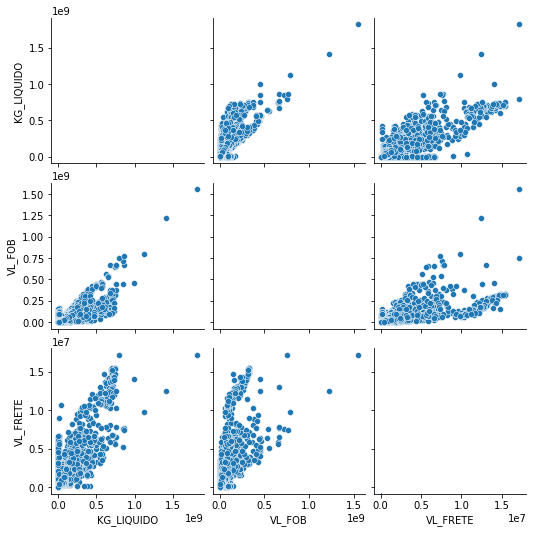

In [13]:
sns.pairplot(df_quantitativas2, kind = "scatter")
plt.show()

In [52]:
df_quantmensal = df_total[['CO_ANO','KG_LIQUIDO','VL_FOB','VL_FRETE']]
df_quantmensal = df_quantmensal.groupby(['CO_ANO']).sum()
df_quantmensal.reset_index(inplace=True)
df_quantmensal.head()

,CO_ANO,KG_LIQUIDO,VL_FOB,VL_FRETE
0,2012,54643875431,44422659844,1465987917
1,2013,65147740890,50360622247,1595011857
2,2014,70258813420,49257127564,1629620393
3,2015,64176879008,29416172638,1373484760
4,2016,57038533951,19664440436,1014832747


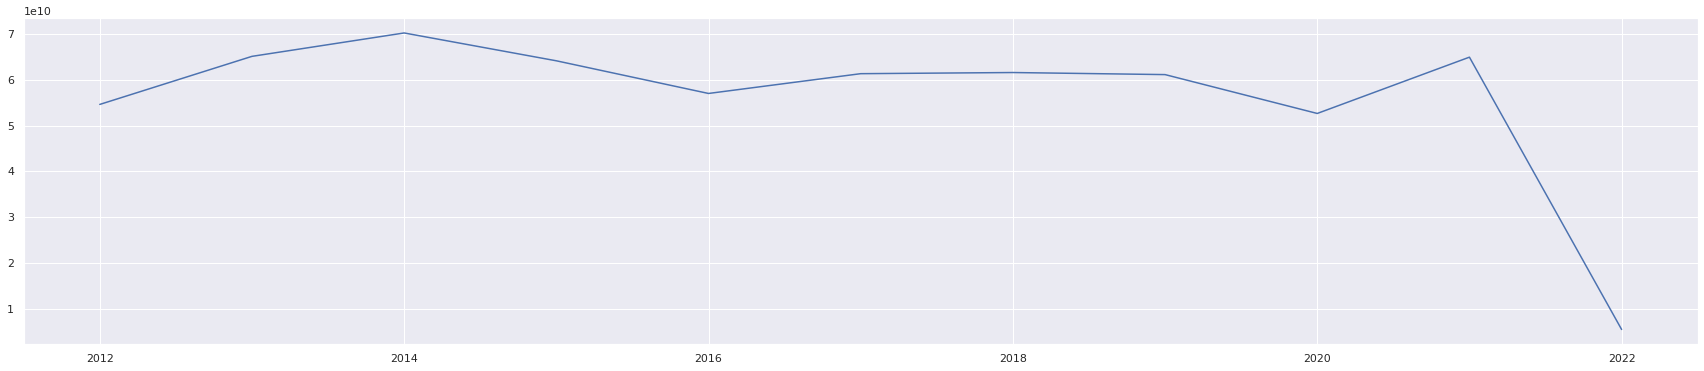

In [53]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(30, 6))
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.KG_LIQUIDO)
plt.show()

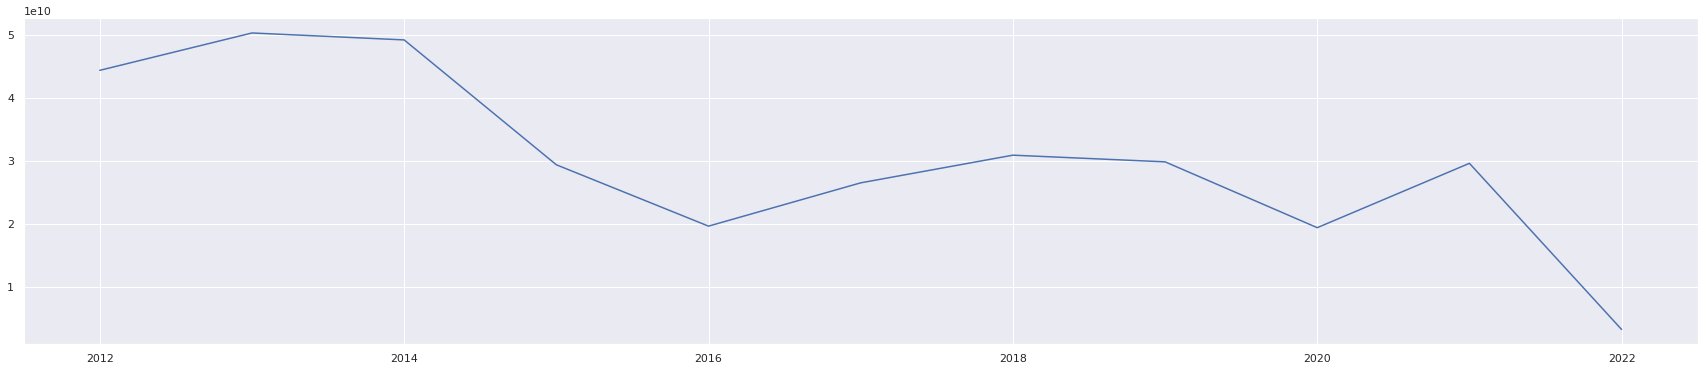

In [54]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(30, 6))
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.VL_FOB)
plt.show()

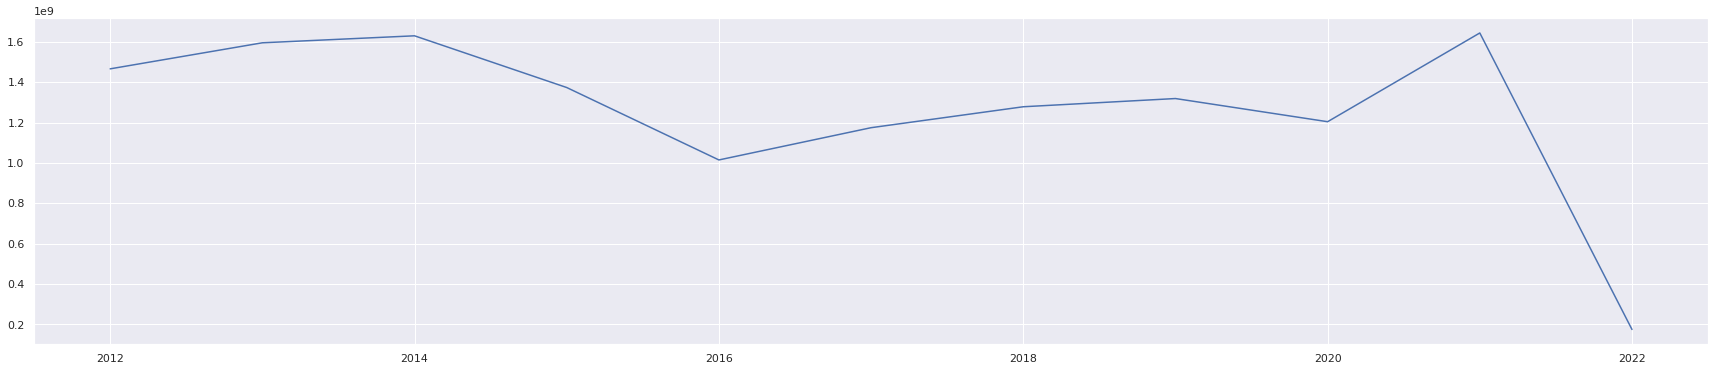

In [55]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(30, 6))
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.VL_FRETE)
plt.show()

In [56]:
df = df_dolar[['ano','COTACAO']]
df

,ano,COTACAO
0,2012,1.788000
1,2012,1.717316
2,2012,1.794045
3,2012,1.856150
4,2012,1.985682
...,...,...
118,2021,5.558900
119,2021,5.658238
120,2022,5.525810
121,2022,5.191053


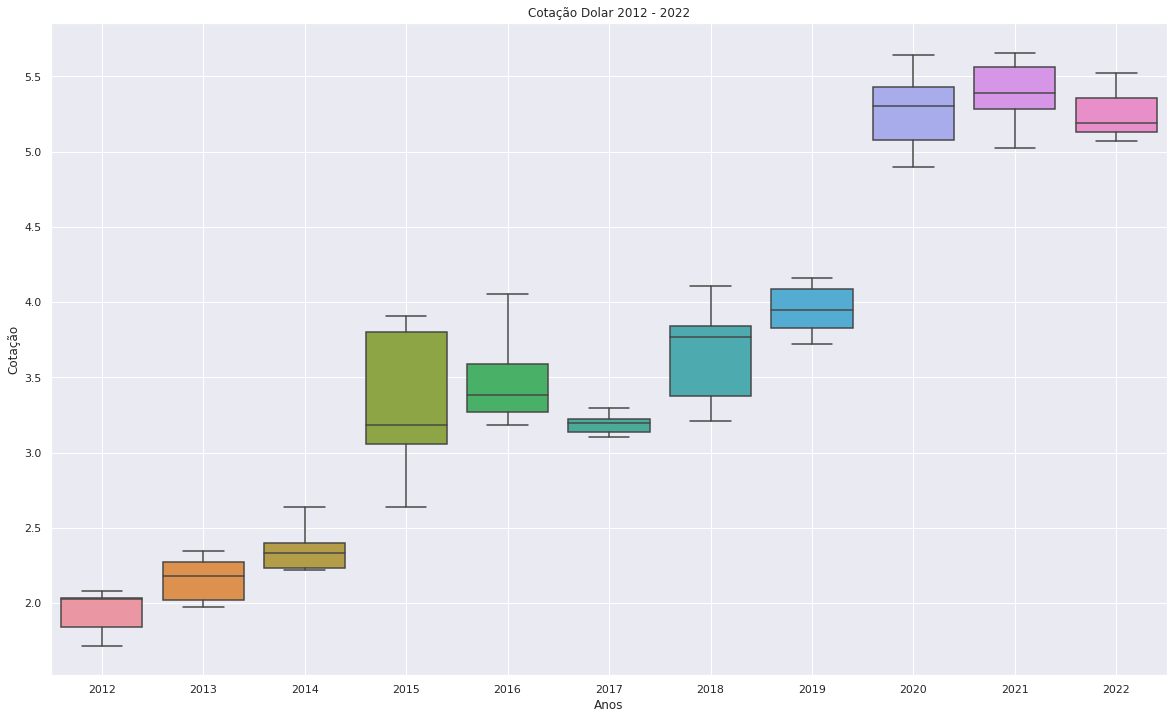

In [57]:
# Configurando tema
sns.set_theme(style="darkgrid")


# Configurando tamanho da figura
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title("Cotação Dolar 2012 - 2022")
sns.boxplot(x='ano', y='COTACAO', data=df, showfliers = False)
ax.set_ylabel("Cotação")
ax.set_xlabel("Anos")
plt.grid(True)
plt.show()

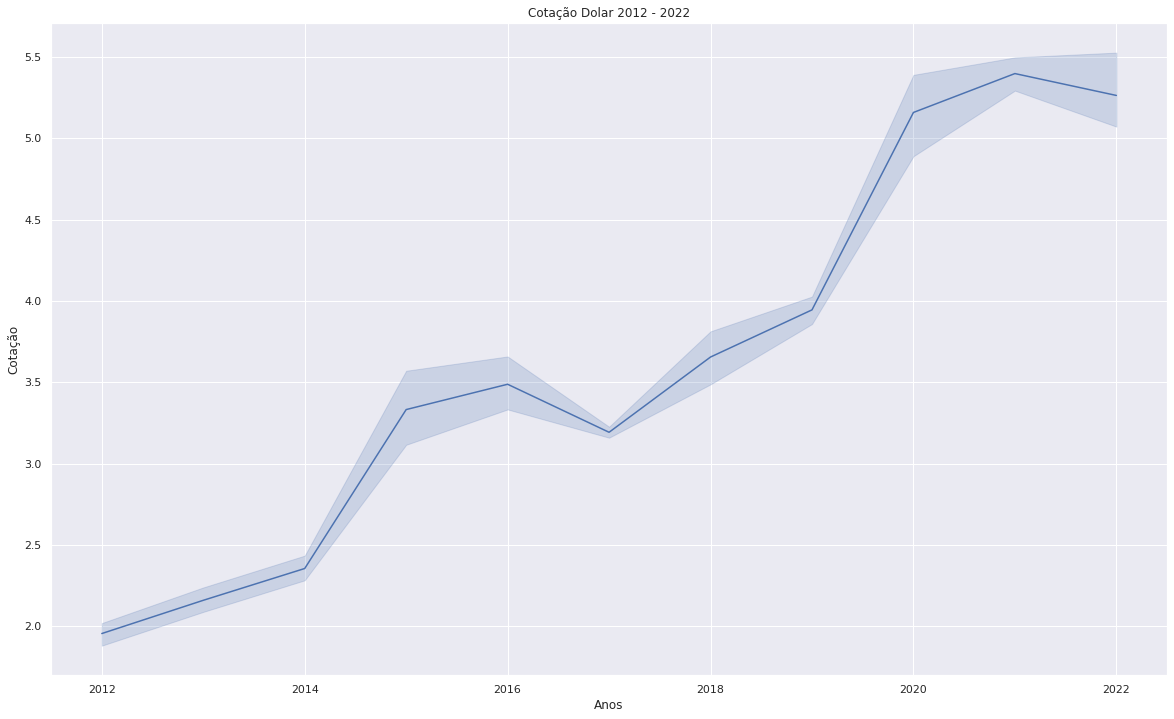

In [58]:
# Configurando tema
sns.set_theme(style="darkgrid")


# Configurando tamanho da figura
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title("Cotação Dolar 2012 - 2022")
sns.lineplot(x='ano', y='COTACAO', data=df)
ax.set_ylabel("Cotação")
ax.set_xlabel("Anos")
plt.grid(True)
plt.show()


## Modelos de Machine Learning
-----


Separando dados para treino e teste

In [101]:
df_final = df_total.copy()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66230 entries, 11 to 18689501
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CO_ANO      66230 non-null  int64  
 1   CO_MES      66230 non-null  int64  
 2   NCM         66230 non-null  object 
 3   NO_PAIS     66230 non-null  object 
 4   SG_UF_NCM   66230 non-null  object 
 5   NO_VIA      66230 non-null  object 
 6   NO_URF      66230 non-null  object 
 7   QT_ESTAT    66230 non-null  int64  
 8   KG_LIQUIDO  66230 non-null  int64  
 9   VL_FOB      66230 non-null  int64  
 10  COTACAO     66230 non-null  float64
 11  FOB_REAIS   66230 non-null  int64  
 12  VL_SEGURO   66230 non-null  int64  
 13  VL_FRETE    66230 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 9.6+ MB


In [102]:
df_sigla = df_final[['SG_UF_NCM']]
df_sigla = df_sigla.drop_duplicates()
df_sigla.reset_index(inplace=True)
df_sigla.drop(['index'],axis=1,inplace=True)
df_sigla.reset_index(inplace=True)
df_sigla.at[3,'index']=0
df_sigla.at[0,'index']=1
df_sigla.at[1,'index']=2
df_sigla.at[2,'index']=3
df_sigla = df_sigla.sort_values(by='index')
df_sigla = df_sigla.rename(columns={"index":"CO_UF_NCM"})
df_sigla

,CO_UF_NCM,SG_UF_NCM
3,0,OUTROS
0,1,SP
1,2,AM
2,3,RJ
4,4,MG
5,5,ES
6,6,PR
7,7,RS
8,8,PE
9,9,BA


In [120]:
df_final_sub = df_final.merge(df_pais[['NO_PAIS','CO_PAIS']],on='NO_PAIS', how = 'left').copy()
#df_final_sub["CO_PAIS"] = df_final_sub["CO_PAIS"].replace('NaN',0)
df_final_sub["NCM"] = df_final_sub["NCM"].apply(lambda x: str(x)[:8])
#df_final_sub["NCM"] = df_final_sub["NCM"].replace('OUTROS',0)
df_final_sub = df_final_sub.merge(df_sigla[['SG_UF_NCM','CO_UF_NCM']],on='SG_UF_NCM',how = 'left')
df_final_sub = df_final_sub.merge(df_via[['NO_VIA','CO_VIA']],on='NO_VIA',how = 'left')
#df_final_sub["CO_VIA"] = df_final_sub["CO_VIA"].replace('OUTROS',0)
df_final_sub["NO_URF"] = df_final_sub["NO_URF"].apply(lambda x: str(x)[:7])
df_final_sub["NO_URF"] = df_final_sub["NO_URF"].replace('OUTROS',0)
df_final_sub = df_final_sub[['CO_ANO','CO_MES','NCM','CO_PAIS','CO_UF_NCM','CO_VIA','NO_URF','QT_ESTAT','KG_LIQUIDO','VL_FOB','COTACAO','VL_SEGURO','VL_FRETE']]
df_final_sub.fillna(value = 0,  
          inplace = True)
df_final_sub


,CO_ANO,CO_MES,NCM,CO_PAIS,CO_UF_NCM,CO_VIA,NO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,COTACAO,VL_SEGURO,VL_FRETE
0,2012,10,85299020,399.0,1,4.0,0817700,5546,5546,282065,2.029591,640,50113
1,2012,10,85177099,399.0,2,4.0,0817700,250000,16,232825,2.029591,161,698
2,2012,10,85177099,399.0,1,4.0,0817700,334281,159,283161,2.029591,83,4927
3,2012,10,85299020,249.0,3,4.0,0817700,1,1,1785,2.029591,2,57
4,2012,10,85299020,249.0,0,4.0,0817700,14863,14863,447108,2.029591,568,245502
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66225,2017,7,27090010,0.0,7,1.0,1015400,95830,71211513,25201076,3.200524,0,1283000
66226,2017,7,27101921,249.0,3,1.0,0,12021,10260493,4568995,3.200524,0,323036
66227,2017,7,27112100,97.0,11,8.0,0145200,363662702,363662702,66392477,3.200524,0,9774146
66228,2017,7,27112100,97.0,10,8.0,0,1882,1882,519416,3.200524,0,96006


In [121]:
from sklearn.model_selection import train_test_split

X, y = df_final_sub.drop(['VL_FRETE'],axis=1), df_final_sub.VL_FRETE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

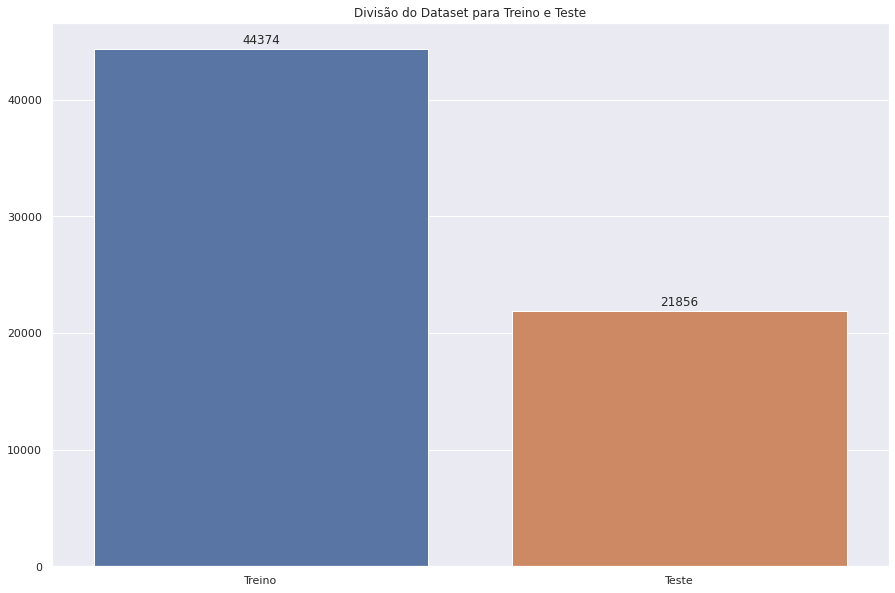

In [122]:
# Configurando Tema
sns.set_theme(style="darkgrid")

# Configurando tamanho da figura
fig, ax = plt.subplots(figsize=(15,10))
bar = sns.barplot(y=[X_train.shape[0],X_test.shape[0]],x=['Treino','Teste'])

for p in bar.patches:
    bar.annotate(int(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
ax.set_title("Divisão do Dataset para Treino e Teste")
plt.show()

## Treinamento

In [123]:
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score

In [124]:
def treinamento_metricas(clf,X_train, X_test, y_train, y_test):
    clf.fit(X_train,y_train)
    predict = clf.predict(X_test)
    r2 = r2_score(y_test, predict)
    mae = median_absolute_error(y_test, predict)

    soma = 0
    regr_y_test = []
    for val in y_test:
        soma += val
        regr_y_test.append(soma)

    soma = 0
    regr_y_predict = []
    for val in clf.predict(X_test):
        soma += val
        regr_y_predict.append(soma)

    # Configurando Tema
    sns.set_theme(style="darkgrid")

    # Configurando grafico
    fig, ax = plt.subplots(figsize=(15,10))

    plt.plot(range(len(regr_y_test)),regr_y_test,label='Gabarito')

    plt.plot(range(len(regr_y_predict)),regr_y_predict,label='Predição')

    ax.set_title('Progressão Aritmética Predição e Gabarito')

    plt.legend()
    plt.show()
    
    return r2,mae

## Decision Tree

In [125]:
from sklearn.tree import DecisionTreeRegressor

In [126]:
tree = DecisionTreeRegressor()

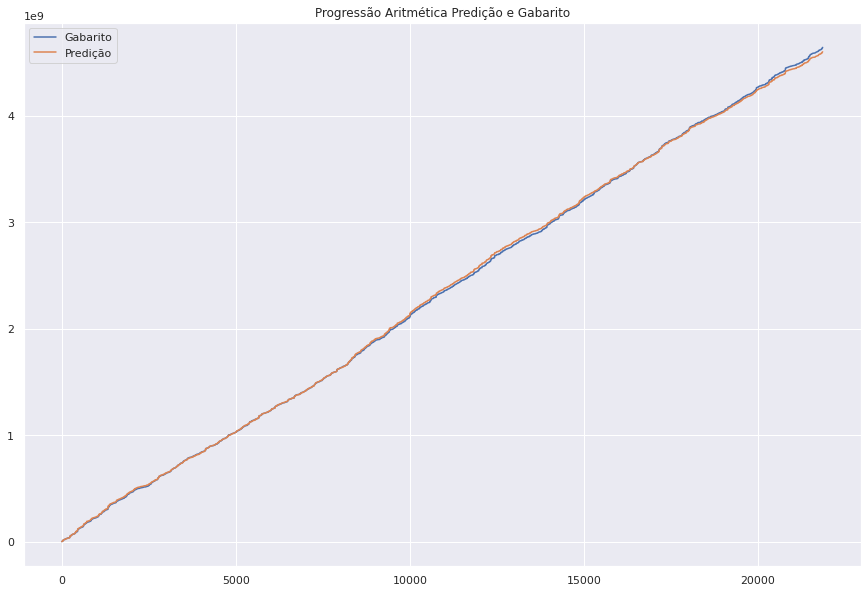

In [127]:
r2, mae = treinamento_metricas(tree,X_train, X_test, y_train, y_test)

In [128]:
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.9001328416910003
MAE: 661.0



## K-Neighbors

In [129]:
from sklearn.neighbors import KNeighborsRegressor

In [130]:
knn = KNeighborsRegressor()

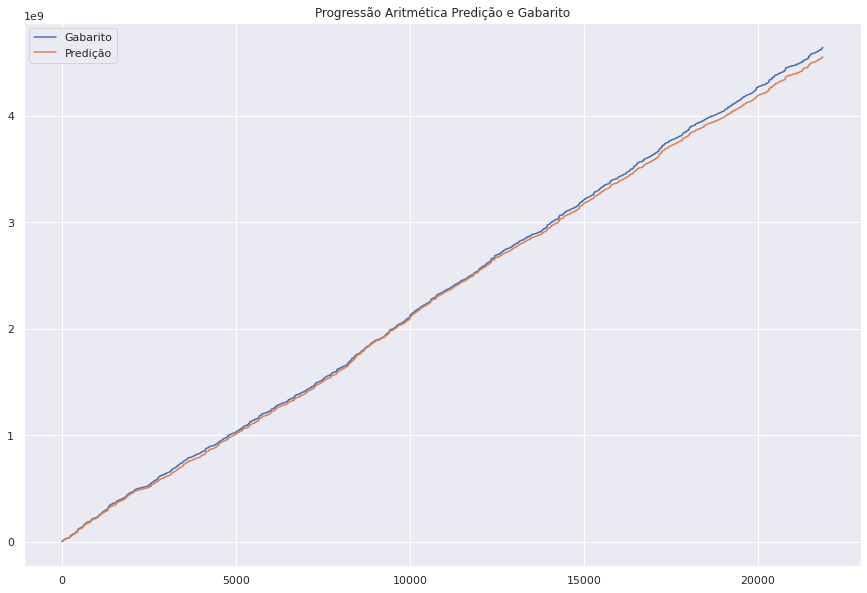

In [131]:
r2, mae = treinamento_metricas(knn,X_train, X_test, y_train, y_test)

In [132]:
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.8673671655188244
MAE: 1252.8000000000002



## Random Forest

In [133]:
from sklearn.ensemble import RandomForestRegressor

In [134]:
rfr = RandomForestRegressor(random_state=42)

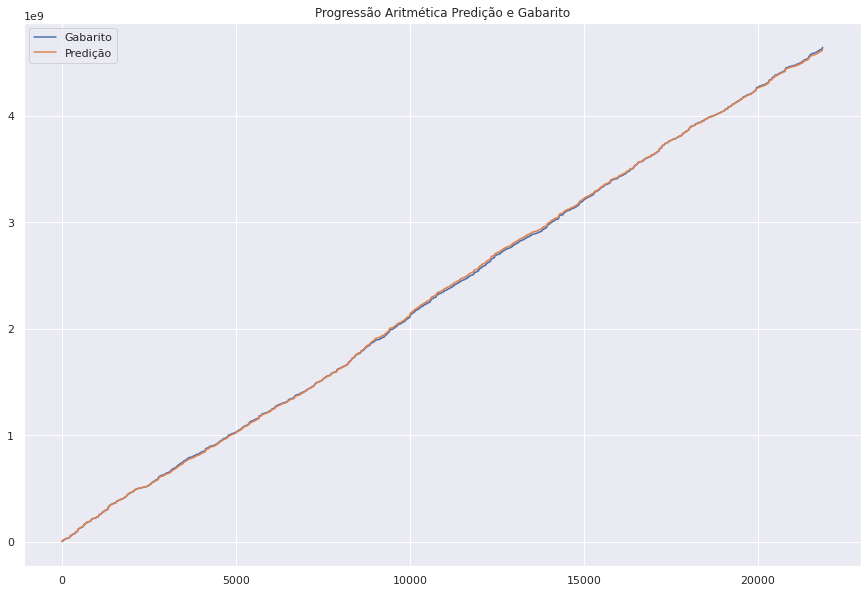

In [135]:
r2, mae = treinamento_metricas(rfr,X_train, X_test, y_train, y_test)

In [136]:
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.949648079647211
MAE: 578.7



### Exportando modelo
-----


In [138]:
import pickle
with open("model.mod","wb") as outfile:
    pickle.dump(rfr,outfile)

## Importando melhor modelo
-----


In [139]:
rfr = pickle.load(open("model.mod","rb"))

In [143]:
print(f"Predicao do modelo: {rfr.predict(X_test)[0]}")
print(f"Valor real: {y_test[0]}")

Predicao do modelo: 218.93


KeyError: ignored

### Restante
-----


In [ ]:
df_importacao = df_importacao[df_importacao.VL_FOB > 0]
df_importacao.info()
df_importacao.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268821 entries, 17700329 to 36389684
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   CO_ANO      268821 non-null  int64 
 1   CO_MES      268821 non-null  int64 
 2   CO_NCM      268821 non-null  int64 
 3   CO_UNID     268821 non-null  int64 
 4   CO_PAIS     268821 non-null  int64 
 5   SG_UF_NCM   268821 non-null  object
 6   CO_VIA      268821 non-null  int64 
 7   CO_URF      268821 non-null  int64 
 8   QT_ESTAT    268821 non-null  int64 
 9   KG_LIQUIDO  268821 non-null  int64 
 10  VL_FOB      268821 non-null  int64 
 11  VL_FRETE    268821 non-null  int64 
 12  VL_SEGURO   268821 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 28.7+ MB


,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
17700329,2012,12,85369090,11,249,MG,1,817800,4727460,3036,152808,4743,78
17700358,2012,3,85045000,11,160,AM,1,227600,23941008,25934,973057,20817,1280
17700372,2012,2,31042090,10,149,GO,1,817800,6900000,6900000,3656925,207000,6769
17700456,2012,5,85332120,11,383,SP,4,817700,2336047,86,27603,1143,24
17700526,2012,3,85369040,11,399,RS,4,1017600,97819,163,21980,2450,35


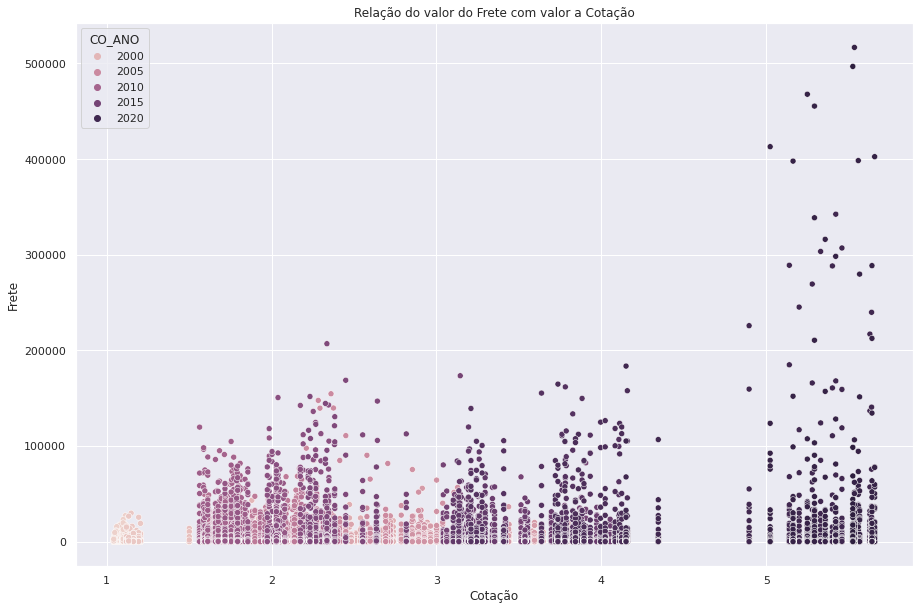

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df_produto,x='COTACAO',y='VL_FRETE',hue='CO_ANO')
ax.set_xlabel('Cotação')
ax.set_ylabel('Frete')

ax.set_title('Relação do valor do Frete com valor a Cotação')

plt.show()

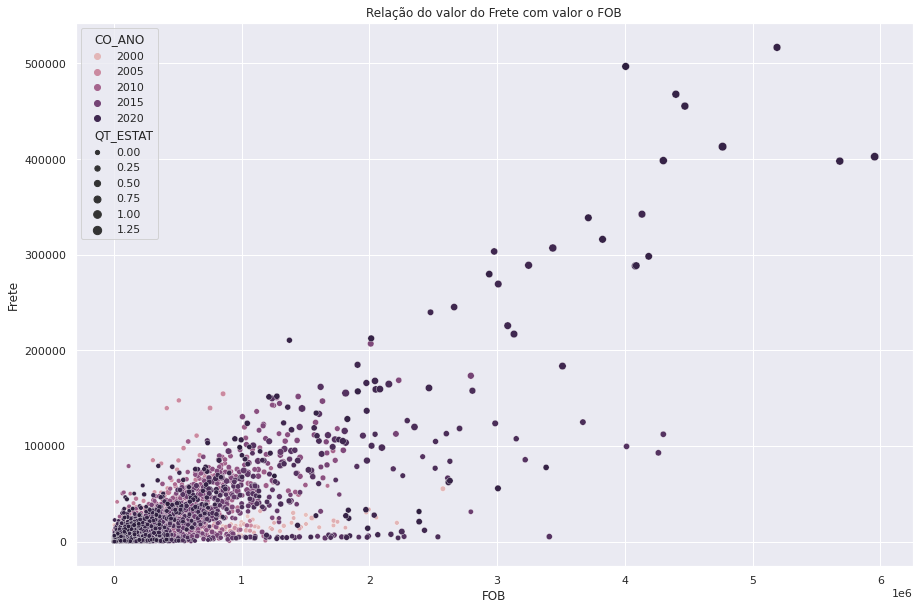

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df_produto,x='VL_FOB',y='VL_FRETE',size='QT_ESTAT',hue='CO_ANO')
ax.set_ylabel('Frete')
ax.set_xlabel('FOB')

ax.set_title('Relação do valor do Frete com valor o FOB')

plt.show()

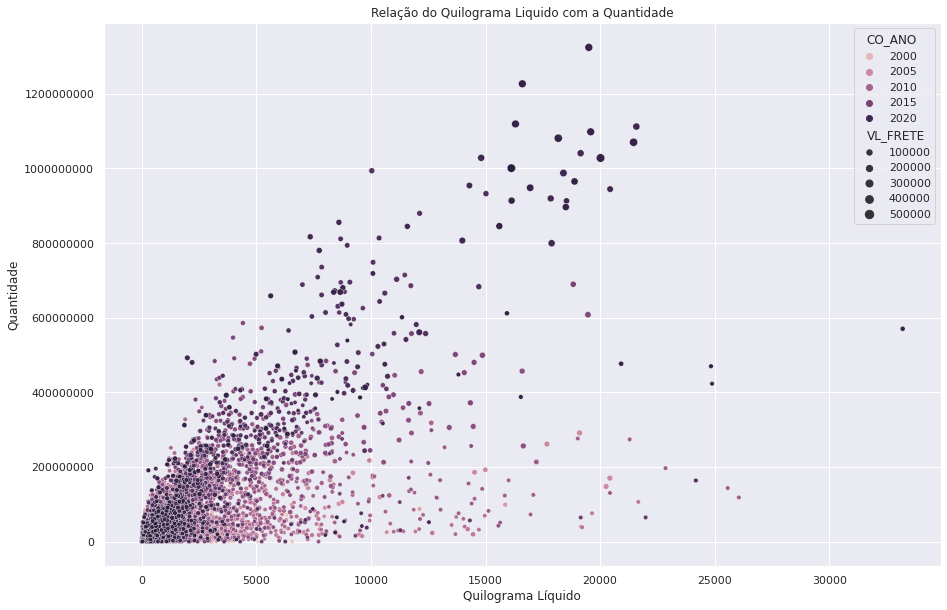

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
g = sns.scatterplot(data=df_produto,x='KG_LIQUIDO',y='QT_ESTAT',size='VL_FRETE',hue='CO_ANO')
ax.set_xlabel('Quilograma Líquido')
ax.set_ylabel('Quantidade')

ax.set_title('Relação do Quilograma Liquido com a Quantidade')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: int(y)))